# Lets create a Recommendation system for the Henry coefficients of porous materials

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os
import scipy
import matplotlib

## We will use the Henry Coefficient matrix, created in `HenryMatrix.ipynb`

In [2]:
_henry_df = pd.read_csv('data/henry_matrix_df_l_5.csv')
_henry_df.set_index(list(_henry_df)[0], inplace=True)
_henry_df.head(10)

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,QQONPFPTGQHPMA-UHFFFAOYSA-N_298K,ATUOYWHBWRKTHZ-UHFFFAOYSA-N_298K,HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K,UFHFLCQGNIYNRP-UHFFFAOYSA-N_298K,FHNFHKCVQCLJFQ-UHFFFAOYSA-N_298K,DNNSSWSSYDEUBZ-UHFFFAOYSA-N_298K,...,CSCPPACGZOOCGX-UHFFFAOYSA-N_298K,IJDNQMDRQITEOD-UHFFFAOYSA-N_298K,KFZMGEQAYNKOFK-UHFFFAOYSA-N_298K,BDERNNFJNOPAEC-UHFFFAOYSA-N_298K,YXFVVABEGXRONW-UHFFFAOYSA-N_298K,OFBQJSOFQDEBGM-UHFFFAOYSA-N_298K,URLKBWYHVLBVBO-UHFFFAOYSA-N_298K,RAHZWNYVWXNFOC-UHFFFAOYSA-N_298K,SWQJXJOGLNCZEY-UHFFFAOYSA-N_298K,VXNZUUAINFGPBY-UHFFFAOYSA-N_298K
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.819172,0.144904,0.319406,NaN,24.205553,39.949433,0.001506,0.036228,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,200.460069,22.948550,NaN,NaN
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,89.667314,0.539600,0.893499,0.118636,245.560096,229.943181,NaN,NaN,NaN,NaN,...,NaN,449.618678,NaN,NaN,NaN,NaN,NaN,NaN,0.000592,177.526659
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,2.307321,0.327606,0.506279,0.206581,NaN,NaN,NaN,0.057261,11.828043,2.611847,...,1042.206982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,1.499942,0.225363,0.760417,0.182960,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5929.947398,NaN,NaN,NaN
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,5.201798,0.319807,0.889735,0.330443,622.898203,156.709353,53.408752,0.045899,5.584652,NaN,...,5011.403127,0.929996,NaN,NaN,NaN,19931.673125,NaN,50.780972,NaN,NaN
NIST-MATDB-acbbe796d49416e999dc819f2ae65fe9,5.390284,NaN,1.531124,NaN,NaN,NaN,30.243870,0.080570,2.688955,1.196620,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.625128,NaN,NaN
NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,1.659815,0.217429,0.434413,NaN,NaN,NaN,1.156671,0.038159,0.915070,0.497998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.735938,NaN,NaN
NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f,2.543142,0.210701,0.594988,0.141437,NaN,NaN,NaN,0.023973,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-9ee35322ac5ddba224d845a03c651b29,311.927033,NaN,1.072150,NaN,NaN,NaN,NaN,0.029001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
idx = np.where(_henry_df.values == 0)
idx

(array([], dtype=int64), array([], dtype=int64))

In [4]:
log_henry_df = _henry_df.copy()
#log_henry_df.iat[idx[0][0], idx[1][0]] = np.nan
log_henry_df = np.log(log_henry_df)
log_henry_df.head(10)

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,QQONPFPTGQHPMA-UHFFFAOYSA-N_298K,ATUOYWHBWRKTHZ-UHFFFAOYSA-N_298K,HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K,UFHFLCQGNIYNRP-UHFFFAOYSA-N_298K,FHNFHKCVQCLJFQ-UHFFFAOYSA-N_298K,DNNSSWSSYDEUBZ-UHFFFAOYSA-N_298K,...,CSCPPACGZOOCGX-UHFFFAOYSA-N_298K,IJDNQMDRQITEOD-UHFFFAOYSA-N_298K,KFZMGEQAYNKOFK-UHFFFAOYSA-N_298K,BDERNNFJNOPAEC-UHFFFAOYSA-N_298K,YXFVVABEGXRONW-UHFFFAOYSA-N_298K,OFBQJSOFQDEBGM-UHFFFAOYSA-N_298K,URLKBWYHVLBVBO-UHFFFAOYSA-N_298K,RAHZWNYVWXNFOC-UHFFFAOYSA-N_298K,SWQJXJOGLNCZEY-UHFFFAOYSA-N_298K,VXNZUUAINFGPBY-UHFFFAOYSA-N_298K
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,-0.199461,-1.931683,-1.141293,NaN,3.186582,3.687614,-6.497979,-3.317934,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.300615,3.133255,NaN,NaN
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,4.496106,-0.616928,-0.112610,-2.131697,5.503542,5.437832,NaN,NaN,NaN,NaN,...,NaN,6.108400,NaN,NaN,NaN,NaN,NaN,NaN,-7.431217,5.179121
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,0.836087,-1.115944,-0.680668,-1.577064,NaN,NaN,NaN,-2.860130,2.470473,0.960058,...,6.949096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,0.405427,-1.490043,-0.273888,-1.698487,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.687771,NaN,NaN,NaN
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,1.649004,-1.140039,-0.116832,-1.107322,6.434383,5.054393,3.977975,-3.081303,1.720022,NaN,...,8.519471,-0.072575,NaN,NaN,NaN,9.900065,NaN,3.927522,NaN,NaN
NIST-MATDB-acbbe796d49416e999dc819f2ae65fe9,1.684598,NaN,0.426002,NaN,NaN,NaN,3.409294,-2.518626,0.989153,0.179501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.555380,NaN,NaN
NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,0.506706,-1.525884,-0.833759,NaN,NaN,NaN,0.145546,-3.266002,-0.088755,-0.697158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.306609,NaN,NaN
NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f,0.933400,-1.557317,-0.519213,-1.955904,NaN,NaN,NaN,-3.730834,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-9ee35322ac5ddba224d845a03c651b29,5.742769,NaN,0.069666,NaN,NaN,NaN,NaN,-3.540434,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
log_henry_df.shape

(101, 32)

In [6]:
#Creates a dictionary of InChIKeys to gas names (and gas names to InChIKeys)
host = "adsorption.nist.gov"
url = "https://" + host + "/isodb/api/gases.json"
gas_data = json.loads(requests.get(url).content)

key_to_gas = {}
for gas in gas_data:
    key_to_gas[gas['InChIKey']] = gas['name']
gas_to_key = dict(map(reversed, key_to_gas.items()))

#Creates a dictionary for hashkeys to material names (and material names to hashkeys)
url = "https://" + host + "/isodb/api/materials.json"
material_data = json.loads(requests.get(url).content)

key_to_material = {}
for material in material_data:
    key_to_material[material['hashkey']] = material['name']
material_to_key = dict(map(reversed, key_to_material.items()))

## Lets also define a function that will randomly split our data into <i>k</i> folds

In [7]:
def k_fold_split(henry_df, k, max_iter=1000):
    assert k > 1, 'Choose a `k` greater than 1, otherwise this function is pointless'
    print('Splitting matrix into {:d} folds'.format(k))
    matrix = henry_df.values
    fold_matrix = np.full_like(matrix, -1, dtype=np.int)
    all_k_folds_not_represented_in_each_column = True
    n_iteration = 0
    while all_k_folds_not_represented_in_each_column:
        n_iteration += 1
        all_k_folds_not_represented_in_each_column = False
        for i_row in range(matrix.shape[0]):
            # Grabs all available indices in row `i_row`
            j_indices = np.where(~np.isnan(matrix[i_row,:]))[0]
            # As long as there are enough data points to distribute between `k` folds, we'll equally distribute them.
            while len(j_indices) >= k:
                for fold in range(k):
                    j = np.random.randint(0, len(j_indices))
                    fold_matrix[i_row, j_indices[j]] = fold
                    j_indices = np.delete(j_indices, j)
            # If there are leftover data points (i.e. #data points left < `k`), we'll randomly assign them into folds
            for j in j_indices:
                fold_matrix[i_row, j] = np.random.randint(0, k)
        # We make sure we have enough data points in the columns as well
        for j_col in range(matrix.shape[1]):
            unique_folds = np.unique(fold_matrix[:, j_col])
            #print(len(vals[~np.isnan(vals)]))
            if len(unique_folds) <= k:
                all_k_folds_not_represented_in_each_column = True
                break
        # If too many iteration are performed an Exception is raised.
        if n_iteration > max_iter:
            raise Exception('Maximum number of iterations reached. Try changing the `max_iter` argument.')
    
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if np.isnan(matrix[i,j]):
                continue
            else:
                assert fold_matrix[i,j] != -1, 'A non-NaN value was not put in a fold'
    
    print('Number of iterations required to split data into {}-folds: {}'.format(k, n_iteration))
    for fold in range(k):
        print('Number of data points in fold {:d}: {:d}'.format(fold, np.sum(fold_matrix == fold)))
    print('Total number of data points: {:d}'.format(np.sum(~np.isnan(henry_df.values))))
    print('-----------------------------------')
    return fold_matrix

fold_matrix = k_fold_split(log_henry_df, 3, max_iter=1e4)

Splitting matrix into 3 folds
Number of iterations required to split data into 3-folds: 164
Number of data points in fold 0: 236
Number of data points in fold 1: 227
Number of data points in fold 2: 243
Total number of data points: 706
-----------------------------------


In [8]:
def sort_matrix_by_freq(material_gas_matrix):
    row_sum = np.sum(material_gas_matrix, axis=1)
    old_row_order = np.arange(len(row_sum))
    new_row_order = sorted(old_row_order, key=lambda x: row_sum[x], reverse=True)
    col_sum = np.sum(material_gas_matrix[new_row_order, :], axis=0)
    old_col_order = np.arange(len(col_sum))
    new_col_order = sorted(old_col_order, key=lambda x: col_sum[x], reverse=True)
    return material_gas_matrix[new_row_order, :][:, new_col_order]

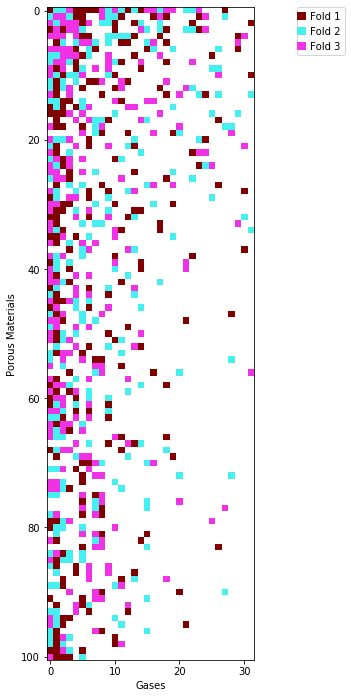

In [9]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
#my_cmap = matplotlib.cm.get_cmap('Accent')
mycmap = matplotlib.colors.ListedColormap(np.array([[255/255, 255/255, 255/255, 1], 
                                                    [128/255, 0, 0, 1], 
                                                    [70/255, 240/255, 240/255, 1], 
                                                    [240/255, 50/255, 230/255, 1],
                                                    [60/255, 180/255, 75/255, 1],
                                                    [245/255, 130/255, 48/255, 1]][:len(np.unique(fold_matrix))]))
plt.imshow(sort_matrix_by_freq(fold_matrix), interpolation='none', cmap=mycmap)
custom_points = [matplotlib.lines.Line2D([0], [0], color=mycmap(1), lw=8),
                 matplotlib.lines.Line2D([0], [0], color=mycmap(2), lw=8),
                 matplotlib.lines.Line2D([0], [0], color=mycmap(3), lw=8)]
plt.legend(custom_points, ['Fold 1', 'Fold 2', 'Fold 3'], handlelength=0.1,
           bbox_to_anchor=(1.44,1), borderaxespad=0)
ax.set_xlabel('Gases')
ax.set_ylabel('Porous Materials')
#cbar = plt.colorbar()
#cbar.set_label('Fold', fontsize=14, rotation=270, labelpad=25)
#ax.axis('auto')
plt.savefig('pics/foldmatrix.png', format='png', dpi=300)
plt.show()

### Lets start setting up the Recommender System algorithm

M shape: (2, 101)	G shape: (2, 32)
Train Loss on iteration 0: 1612.5896770914185
-------------
Maximum number of iterations (100) reached.


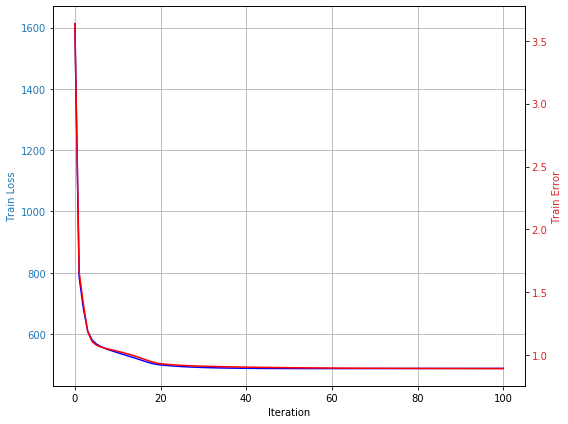

In [10]:
def ALS(henry_matrix, r, lambd, threshold, convergence=1e-6, maxiter=20000, use_bias=True, use_global_average=True, verbose=True):
    n = 0
    train_error_arr = []
    train_error = np.inf
    prev_error = 0
    
    loss_arr = []
    loss = np.inf
    prev_loss = 0
    
    convergence_cnt = 0
    nm = henry_matrix.shape[0]
    ng = henry_matrix.shape[1]
        
    M = np.random.rand(r, nm)-0.5
    G = np.random.rand(r, ng)-0.5
    mu = np.random.rand(1, nm)-0.5
    gamma = np.random.rand(1, ng)-0.5
    hbar = np.nanmean(henry_matrix) if use_global_average else 0
    Im = lambd[0] * np.identity(r)
    Ig = lambd[1] * np.identity(r)
    
    if verbose:
        print('M shape: {}\tG shape: {}'.format(M.shape, G.shape))
    while train_error > threshold:
        for m in np.random.choice(M.shape[1], M.shape[1], False):
            gases_in_which_H_of_this_mof_is_measured = ~np.isnan(henry_matrix[m,:])
            biased_H = np.reshape(henry_matrix[m, gases_in_which_H_of_this_mof_is_measured] -\
                (hbar + gamma[0, gases_in_which_H_of_this_mof_is_measured] + mu[0, m]), 
                                  (1, np.sum(gases_in_which_H_of_this_mof_is_measured)))
            b = (G[:, gases_in_which_H_of_this_mof_is_measured]).dot(biased_H.T)
            A = G[:, gases_in_which_H_of_this_mof_is_measured].dot(G[:, gases_in_which_H_of_this_mof_is_measured].T) + Im
            M[:,m] = np.linalg.solve(A,b.flatten())
            mu[0, m] = (np.sum([henry_matrix[m, g] - gamma[0, g] - hbar - M[:,m].T.dot(G[:,g])\
                                     for g in np.arange(ng)[gases_in_which_H_of_this_mof_is_measured]]))\
                                        /(np.sum(gases_in_which_H_of_this_mof_is_measured) + lambd[0])
        for g in np.random.choice(G.shape[1], G.shape[1], False):
            mofs_in_which_H_of_this_gas_is_measured = ~np.isnan(henry_matrix[:,g])
            biased_H = np.reshape(henry_matrix[mofs_in_which_H_of_this_gas_is_measured, g] -\
                (hbar + mu[0, mofs_in_which_H_of_this_gas_is_measured] + gamma[0, g]),
                                  (np.sum(mofs_in_which_H_of_this_gas_is_measured), 1))
            b = M[:,mofs_in_which_H_of_this_gas_is_measured].dot(biased_H)
            A = M[:,mofs_in_which_H_of_this_gas_is_measured].dot(M[:,mofs_in_which_H_of_this_gas_is_measured].T) + Ig
            G[:,g] = np.linalg.solve(A,b.flatten())
            gamma[0, g] = (np.sum([henry_matrix[m, g] - mu[0, m] - hbar - M[:,m].T.dot(G[:,g])\
                                     for m in np.arange(nm)[mofs_in_which_H_of_this_gas_is_measured]]))\
                                    /(np.sum(mofs_in_which_H_of_this_gas_is_measured) + lambd[1])
            
        pred = (M.T.dot(G) + hbar + mu.T + gamma)[~np.isnan(henry_matrix)]
        actual = henry_matrix[~np.isnan(henry_matrix)]
        prev_error = train_error
        train_error = np.sum([(actual - pred)**2])/len(pred)
        train_error_arr.append(train_error)
        error_diff = np.abs(prev_error - train_error)
        prev_loss = loss
        loss = 0.5 * np.sum((henry_matrix[~np.isnan(henry_matrix)] - pred)**2) \
                + 0.5 * lambd[0] * np.sum([np.linalg.norm(M[:,m])**2 for m in range(nm)]) \
                + 0.5 * lambd[1] * np.sum([np.linalg.norm(G[:,g])**2 for g in range(ng)])
        loss_arr.append(loss)
        loss_diff = np.abs(prev_loss - loss)
        if n % 1000 == 0:
            if verbose:
                print('Train Loss on iteration {}: {}\n-------------'.format(n, loss))
            
        if loss_diff < convergence:
            convergence_cnt += 1
            if convergence_cnt > 199:
                if verbose:
                    print('Training has converged after {} iterations. See `convergence` parameter for convergence procedure.'.format(n))
                    print('Train loss: {}'.format(loss))
                break
        else:
            convergence_cnt = 0
        n += 1
        if n > maxiter:
            print('Maximum number of iterations ({}) reached.'.format(maxiter))
            break
        if np.count_nonzero(np.isnan(M)) > 0 or np.count_nonzero(np.isnan(G)) > 0:
            raise Exception('NaN encountered in either latent representation')
    
    if verbose:
        fig, ax = plt.subplots(figsize=(8,6))
        #ax.scatter(np.arange(len(train_error_arr)), train_error_arr, color='red')
        ax.plot(np.arange(len(loss_arr)), loss_arr, color='blue')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Train Loss', color='tab:blue')
        ax.tick_params(axis='y', labelcolor='tab:blue')
        plt.grid('on')
        
        ax2 = ax.twinx()
        ax2.plot(np.arange(len(train_error_arr)), train_error_arr, color='red')
        ax2.set_ylabel('Train Error', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        
        plt.tight_layout()
        plt.show()
    
    return M, G, mu, gamma, train_error_arr[-1], loss_arr[-1], hbar
m, g, mb, gb, err, loss, hbar = ALS(log_henry_df.values, 2, [1.0, 1.0], 1e-5, maxiter=100)

M shape: (2, 101)	G shape: (2, 32)
Train Loss on iteration 0: 1408.2477268880705
-------------
Maximum number of iterations (100) reached.


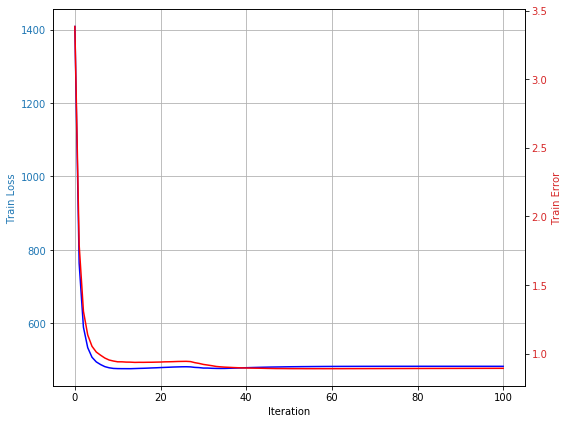

In [11]:
def ALSv2(henry_matrix, r, lambd, threshold, convergence=1e-6, maxiter=20000, use_bias=True, use_global_average=True, verbose=True):
    n = 0
    train_error_arr = []
    train_error = np.inf
    prev_error = 0
    
    loss_arr = []
    loss = np.inf
    prev_loss = 0
    
    convergence_cnt = 0
    nm = henry_matrix.shape[0]
    ng = henry_matrix.shape[1]
    percent_nm = nm/(nm+ng)
    percent_ng = 1-percent_nm
        
    M = np.random.rand(r, nm)-0.5
    G = np.random.rand(r, ng)-0.5
    mu = np.random.rand(1, nm)-0.5
    gamma = np.random.rand(1, ng)-0.5
    hbar = np.nanmean(henry_matrix) if use_global_average else 0
    Im = lambd[0] * np.identity(r)
    Ig = lambd[1] * np.identity(r)
    
    if verbose:
        print('M shape: {}\tG shape: {}'.format(M.shape, G.shape))
    while train_error > threshold:
        m_to_pick = np.random.choice(M.shape[1], M.shape[1], False)
        g_to_pick = np.random.choice(G.shape[1], G.shape[1], False)
        while len(m_to_pick) != 0 or len(g_to_pick) != 0:
            if len(g_to_pick) == 0 or (np.random.rand() <= percent_nm and len(m_to_pick) > 0):
                m = m_to_pick[0]
                m_to_pick = np.delete(m_to_pick, 0)
                gases_in_which_H_of_this_mof_is_measured = ~np.isnan(henry_matrix[m,:])
                biased_H = np.reshape(henry_matrix[m, gases_in_which_H_of_this_mof_is_measured] -\
                        (hbar + gamma[0, gases_in_which_H_of_this_mof_is_measured] + mu[0, m]), 
                                      (1, np.sum(gases_in_which_H_of_this_mof_is_measured)))
                b = (G[:, gases_in_which_H_of_this_mof_is_measured]).dot(biased_H.T)
                A = G[:, gases_in_which_H_of_this_mof_is_measured].dot(G[:, gases_in_which_H_of_this_mof_is_measured].T) + Im
                M[:,m] = np.linalg.solve(A,b.flatten())
                mu[0, m] = (np.sum([henry_matrix[m, g] - gamma[0, g] - hbar - M[:,m].T.dot(G[:,g])\
                                         for g in np.arange(ng)[gases_in_which_H_of_this_mof_is_measured]]))\
                                            /(np.sum(gases_in_which_H_of_this_mof_is_measured) + lambd[0])
            else:
                g = g_to_pick[0]
                g_to_pick = np.delete(g_to_pick, 0)
                mofs_in_which_H_of_this_gas_is_measured = ~np.isnan(henry_matrix[:,g])
                biased_H = np.reshape(henry_matrix[mofs_in_which_H_of_this_gas_is_measured, g] -\
                    (hbar + mu[0, mofs_in_which_H_of_this_gas_is_measured] + gamma[0, g]),
                                      (np.sum(mofs_in_which_H_of_this_gas_is_measured), 1))
                b = M[:,mofs_in_which_H_of_this_gas_is_measured].dot(biased_H)
                A = M[:,mofs_in_which_H_of_this_gas_is_measured].dot(M[:,mofs_in_which_H_of_this_gas_is_measured].T) + Ig
                G[:,g] = np.linalg.solve(A,b.flatten())
                gamma[0, g] = (np.sum([henry_matrix[m, g] - mu[0, m] - hbar - M[:,m].T.dot(G[:,g])\
                                         for m in np.arange(nm)[mofs_in_which_H_of_this_gas_is_measured]]))\
                                        /(np.sum(mofs_in_which_H_of_this_gas_is_measured) + lambd[1])
        pred = (M.T.dot(G) + hbar + mu.T + gamma)[~np.isnan(henry_matrix)]
        actual = henry_matrix[~np.isnan(henry_matrix)]
        prev_error = train_error
        train_error = np.sum([(actual - pred)**2])/len(pred)
        train_error_arr.append(train_error)
        error_diff = np.abs(prev_error - train_error)
        prev_loss = loss
        loss = 0.5 * np.sum((henry_matrix[~np.isnan(henry_matrix)] - pred)**2) \
                + 0.5 * lambd[0] * np.sum([np.linalg.norm(M[:,m])**2 for m in range(nm)]) \
                + 0.5 * lambd[1] * np.sum([np.linalg.norm(G[:,g])**2 for g in range(ng)])
        loss_arr.append(loss)
        loss_diff = np.abs(prev_loss - loss)
        if n % 1000 == 0:
            if verbose:
                print('Train Loss on iteration {}: {}\n-------------'.format(n, loss))
            
        if loss_diff < convergence:
            convergence_cnt += 1
            if convergence_cnt > 199:
                if verbose:
                    print('Training has converged after {} iterations. See `convergence` parameter for convergence procedure.'.format(n))
                    print('Train loss: {}'.format(loss))
                break
        else:
            convergence_cnt = 0
        n += 1
        if n > maxiter:
            if verbose:
                print('Maximum number of iterations ({}) reached.'.format(maxiter))
            break
        if np.count_nonzero(np.isnan(M)) > 0 or np.count_nonzero(np.isnan(G)) > 0:
            raise Exception('NaN encountered in either latent representation')
    
    if verbose:
        fig, ax = plt.subplots(figsize=(8,6))
        #ax.scatter(np.arange(len(train_error_arr)), train_error_arr, color='red')
        ax.plot(np.arange(len(loss_arr)), loss_arr, color='blue')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Train Loss', color='tab:blue')
        ax.tick_params(axis='y', labelcolor='tab:blue')
        plt.grid('on')
        
        ax2 = ax.twinx()
        ax2.plot(np.arange(len(train_error_arr)), train_error_arr, color='red')
        ax2.set_ylabel('Train Error', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        
        plt.tight_layout()
        plt.show()
    
    return M, G, mu, gamma, train_error_arr[-1], loss_arr[-1], hbar
m, g, mb, gb, err, loss, hbar = ALSv2(log_henry_df.values, 2, [1.0, 1.0], 1e-5, maxiter=100)

averge h test:  0.6425345828712614
average h train:  0.6708976349019597
M shape: (2, 150)	G shape: (2, 500)
Train Loss on iteration 0: 47053.418528402704
-------------
Maximum number of iterations (100) reached.


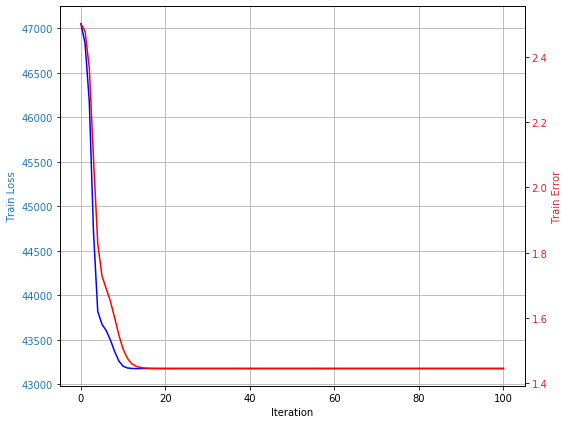

Text(0.5, 1.0, 'Gas Latent Space')

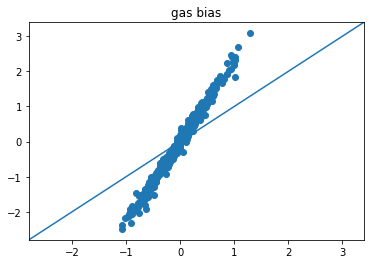

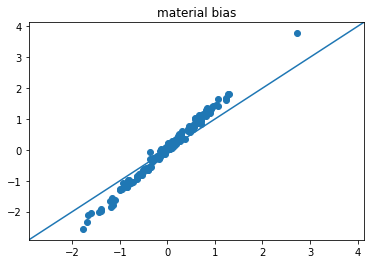

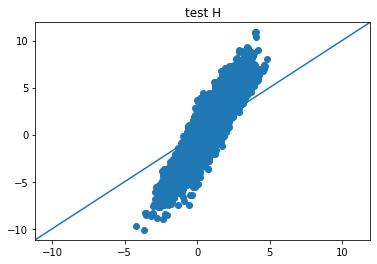

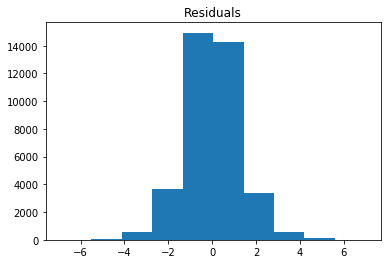

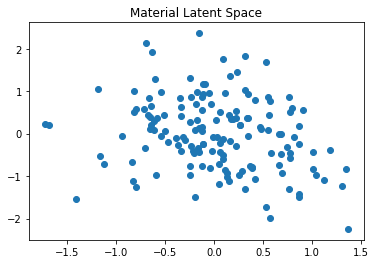

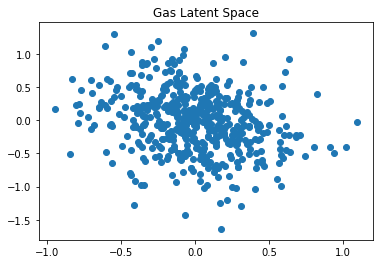

In [12]:
nm = 150
ng = 500
r = 2
M = np.random.randn(r, nm)
G = np.random.randn(r, ng)
gamma = np.random.randn(1, ng)
mu = np.random.randn(1, nm)

H = M.T.dot(G) + gamma + mu.T + 0.6
idx_missing = np.random.randint(0, high=2, size=H.shape) == 0
H_masked = np.copy(H)
H_masked[idx_missing] = np.nan

print("averge h test: ", np.mean(H[idx_missing]))
print("average h train: ", np.mean(H[~idx_missing]))

m, g, mb, gb, err, loss, hbar = ALSv2(H_masked, r, [100.0, 100.0], 1e-5, maxiter=100, use_bias=True, use_global_average=True)
H_pred = m.T.dot(g) + gb + mb.T + hbar

def mk_diagonal():
    lim = ax.get_ylim()
    ax.plot(lim, lim)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    
fig, ax = plt.subplots()
plt.scatter(gb, gamma)
mk_diagonal()
#plt.axis("equal")
ax.set_title("gas bias")

fig, ax = plt.subplots()
plt.scatter(mb, mu)
mk_diagonal()
ax.set_title("material bias")

fig, ax = plt.subplots()
plt.scatter(H_pred[idx_missing], H[idx_missing])
mk_diagonal()
ax.set_title("test H")

fig, ax = plt.subplots()
plt.hist(H_pred[idx_missing] - H[idx_missing])
ax.set_title('Residuals')

fig, ax = plt.subplots()
plt.scatter(m[0,:], m[1,:])
ax.set_title('Material Latent Space')

fig, ax = plt.subplots()
plt.scatter(g[0,:], g[1,:])
ax.set_title('Gas Latent Space')

In [13]:
def cross_validation(henry_df, fold_matrix, r, lambd1, lambd2):
    k = len(np.unique(fold_matrix))-1
    print('-----------------------------------------\nStarting ALS with the following parameters:\nr = {}, lambda = [{:.3e}, {:.3e}]'.format(r, lambd1, lambd2))
    test_errors = []
    parity_pred = np.full(henry_df.shape, np.nan)
    
    for test_fold in range(k):
        M, G, Mbias, Gbias, train_error, loss, hbar = ALSv2(henry_df.mask(fold_matrix == test_fold).values, r, [lambd1, lambd2], 1e-6, 1e-7, 25, use_global_average=True, verbose=False)
        pred = (M.T.dot(G) + Mbias.T + hbar + Gbias)[fold_matrix == test_fold]
        parity_pred[fold_matrix == test_fold] = pred
        actual = henry_df.values[fold_matrix == test_fold]
        test_errors.append(np.sum([(actual - pred)**2])/len(actual))
        #print(train_error)
        #print(test_errors[test_fold])
        #print(actual)
    test_error = np.mean(test_errors)
    print('Test Error: {:.3f}'.format(test_error))
    return test_error, Mbias, Gbias, parity_pred, loss, hbar

_r = [2]
_lambd1 = np.logspace(-2, 6, num=30)
_lambd2 = np.logspace(-6, 1, num=30)
fold_matrix = k_fold_split(log_henry_df, 3, max_iter=10000)
CV_dict = {}
gas_mean_parity_pred = np.zeros(log_henry_df.shape)
mof_mean_parity_pred = np.zeros(log_henry_df.shape)

for r in _r:
    for lambd1 in _lambd1:
        for lambd2 in _lambd2:
            for test_fold in range(3):
                train_mean_gas = np.mean(log_henry_df.mask(fold_matrix == test_fold), axis=0)
                train_mean_material = np.mean(log_henry_df.mask(fold_matrix == test_fold), axis=1)
                for row in range(log_henry_df.shape[0]):
                    for col in range(log_henry_df.shape[1]):
                        if fold_matrix[row,col] == test_fold:
                            gas_mean_parity_pred[row,col] = train_mean_gas[col]
                            mof_mean_parity_pred[row,col] = train_mean_material[row]
            test_error, Mbias, Gbias, parity_pred, loss, hbar = cross_validation(log_henry_df, fold_matrix, r, lambd1, lambd2)
            cv_key = '{}_{}_{}'.format(r, lambd1, lambd2)
            CV_dict['{}_err'.format(cv_key)] = test_error
            CV_dict['{}_pred'.format(cv_key)] = parity_pred
            CV_dict['{}_mbias'.format(cv_key)] = Mbias
            CV_dict['{}_gbias'.format(cv_key)] = Gbias
            CV_dict['{}_r'.format(cv_key)] = r
            CV_dict['{}_lambda1'.format(cv_key)] = lambd1
            CV_dict['{}_lambda2'.format(cv_key)] = lambd2
            CV_dict['{}_loss'.format(cv_key)] = loss
            CV_dict['{}_hbar'.format(cv_key)] = hbar
      

Splitting matrix into 3 folds
Number of iterations required to split data into 3-folds: 35
Number of data points in fold 0: 232
Number of data points in fold 1: 243
Number of data points in fold 2: 231
Total number of data points: 706
-----------------------------------
-----------------------------------------
Starting ALS with the following parameters:
r = 2, lambda = [1.000e-02, 1.000e-06]
Test Error: 103.308
-----------------------------------------
Starting ALS with the following parameters:
r = 2, lambda = [1.000e-02, 1.743e-06]
Test Error: 159.798
-----------------------------------------
Starting ALS with the following parameters:
r = 2, lambda = [1.000e-02, 3.039e-06]
Test Error: 154.328
-----------------------------------------
Starting ALS with the following parameters:
r = 2, lambda = [1.000e-02, 5.298e-06]
Test Error: 415.180
-----------------------------------------
Starting ALS with the following parameters:
r = 2, lambda = [1.000e-02, 9.237e-06]
Test Error: 158.547
----

In [14]:
min_err = np.inf
min_key = "asdf"
for key in CV_dict:
    if key.split('_')[-1] != 'err':
        continue
    if type(CV_dict[key]) != np.float64:
        continue
    if CV_dict[key] < min_err:
        min_err = CV_dict[key]
        min_key = key
        
min_key

'2_529831.6906283702_4.893900918477499e-05_err'

In [15]:
# If key is not none, will return floats as results, otherwise, an array of values from CV run
def extract_data_from_CV_dict(CV_dict, key=None):
    if key:
        parity_pred = CV_dict['_'.join(key.split('_')[:-1]) + '_pred']
        Mbias = CV_dict['_'.join(key.split('_')[:-1]) + '_mbias']
        Gbias = CV_dict['_'.join(key.split('_')[:-1]) + '_gbias']
        r = CV_dict['_'.join(key.split('_')[:-1]) + '_r']
        lambda1 = CV_dict['_'.join(key.split('_')[:-1]) + '_lambda1']
        lambda2 = CV_dict['_'.join(key.split('_')[:-1]) + '_lambda2']
        err = CV_dict['_'.join(key.split('_')[:-1]) + '_err']
        hbar = CV_dict['_'.join(key.split('_')[:-1]) + '_hbar']
    else:
        parity_pred = np.array([])
        Mbias = np.array([])
        Gbias = np.array([])
        r = np.array([], dtype=np.int)
        lambda1 = np.array([])
        lambda2 = np.array([])
        err = np.array([])
        hbar = np.array([])
        for _key in CV_dict.keys():
            parity_pred = np.append(parity_pred, CV_dict['_'.join(_key.split('_')[:-1]) + '_pred'])
            Mbias = np.append(Mbias, CV_dict['_'.join(_key.split('_')[:-1]) + '_mbias'])
            Gbias = np.append(Gbias, CV_dict['_'.join(_key.split('_')[:-1]) + '_gbias'])
            r = np.append(r, CV_dict['_'.join(_key.split('_')[:-1]) + '_r'])
            lambda1 = np.append(lambda1, CV_dict['_'.join(_key.split('_')[:-1]) + '_lambda1'])
            lambda2 = np.append(lambda2, CV_dict['_'.join(_key.split('_')[:-1]) + '_lambda2'])
            err = np.append(err, CV_dict['_'.join(_key.split('_')[:-1]) + '_err'])
            hbar = np.append(hbar, CV_dict['_'.join(_key.split('_')[:-1]) + '_hbar'])
    return parity_pred, Mbias, Gbias, r, lambda1, lambda2, err, hbar
parity_pred, Mbias, Gbias, r, lambda1, lambda2, err, hbar = extract_data_from_CV_dict(CV_dict, key=min_key)

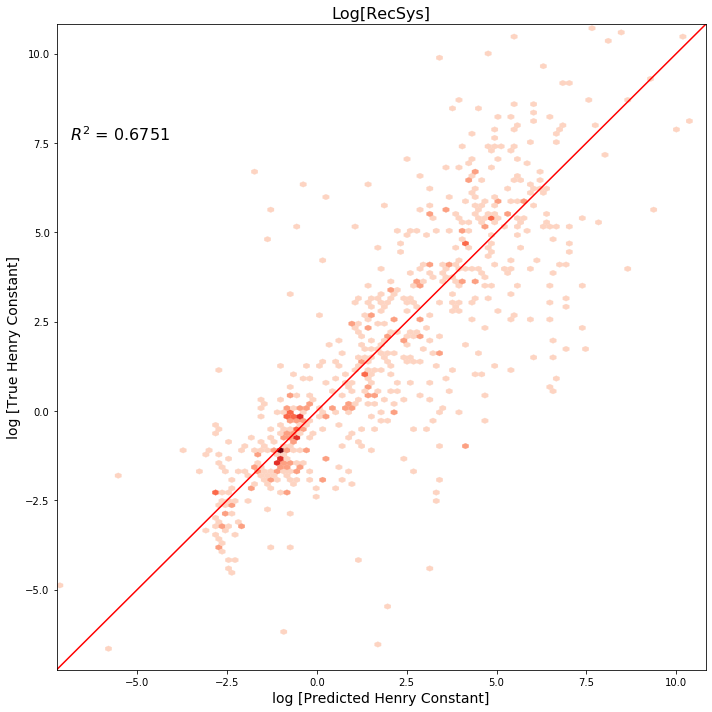

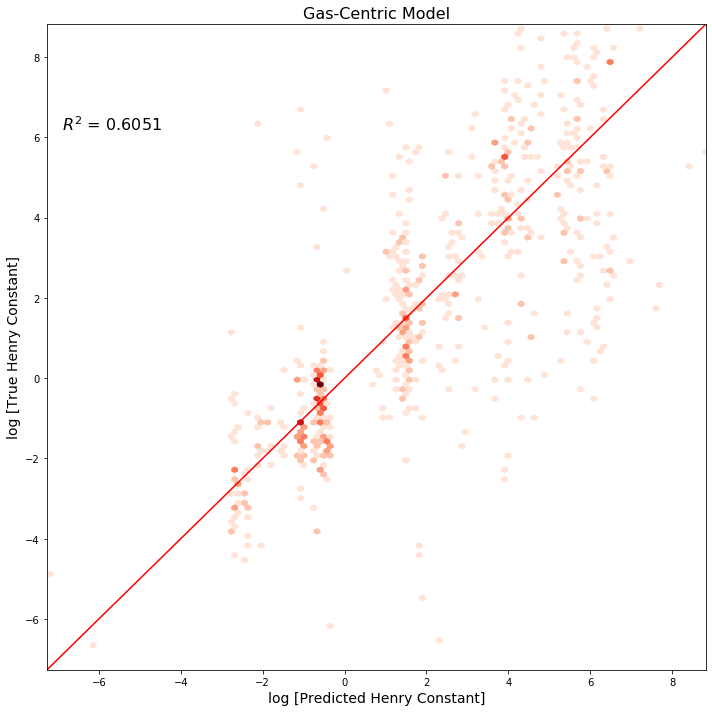

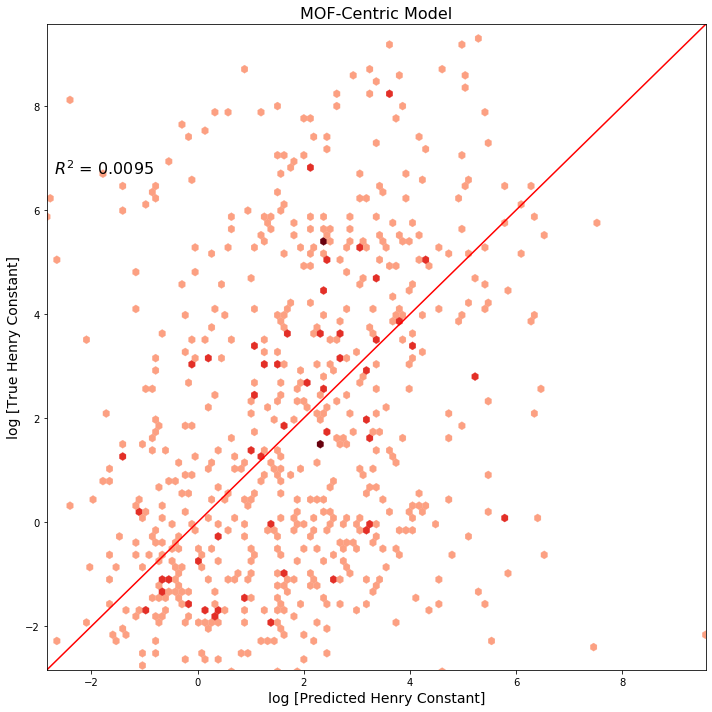

In [16]:
def parity_plot(actual, parity_pred, title):
    fig, ax = plt.subplots(figsize=(10,10))
    
    prediction = parity_pred.flatten()
    actual = actual.values.flatten()
    mask = ~np.isnan(actual)
    
    # Here a colormap was rigged so the background of the parity plots would be transparent
    my_cmap = plt.cm.get_cmap('Reds')
    colors = my_cmap(np.arange(my_cmap.N))
    colors[0,3] = 0.0
    my_cmap = matplotlib.colors.ListedColormap(colors)

    test_mean = np.nanmean(actual)
    R_squared = 1 - (np.sum([(actual[i] - prediction[i])**2 for i in np.arange(len(actual))[mask]]) / np.sum([(actual[i] - test_mean)**2 for i in np.arange(len(actual))[mask]]))
    ax.hexbin(prediction[mask], actual[mask], gridsize=(100,100), cmap=my_cmap, linewidth=0.25)
    #ax.scatter(prediction[mask], actual[mask])
    #lim = [-10, 10]
    
    lim = [np.max([np.min(actual[mask]), np.min(prediction[mask])]), np.min([np.max(actual[mask]), np.max(prediction[mask])])]
    
    ax.plot(lim, lim, c='r')
    ax.set_xlabel('log [Predicted Henry Constant]', fontsize=14)
    ax.set_ylabel('log [True Henry Constant]', fontsize=14)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.text(lim[0]*0.95, lim[1]*0.7, '$R^2$ = {:.4f}'.format(R_squared), fontsize=16)
    ax.set_title(title, fontsize=16)
    plt.tight_layout()
    plt.savefig('pics/' + title + '.png', format='png', dpi=300)
    
    plt.show()
    
parity_plot(log_henry_df, parity_pred, 'Log[RecSys]')
parity_plot(log_henry_df, gas_mean_parity_pred, 'Gas-Centric Model')
parity_plot(log_henry_df, mof_mean_parity_pred, 'MOF-Centric Model')

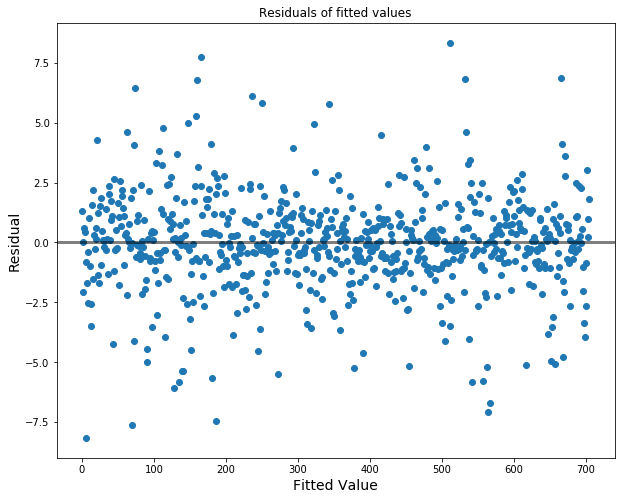

In [35]:
fig, ax = plt.subplots(figsize=(10,8))
mask = ~np.isnan(log_henry_df.values.flatten())
residuals = log_henry_df.values.flatten()[mask] - parity_pred.flatten()[mask]
ax.scatter(np.arange(len(residuals)), residuals)
lim = ax.get_xlim()
ax.plot([-100, 2*lim[1]], [0,0], color='k', linewidth=3, alpha=0.5)
ax.set_xlim(lim)
ax.set_xlabel('Fitted Value', fontsize=14)
ax.set_ylabel('Residual', fontsize=14)
ax.set_title('Residuals of fitted values')
plt.show()

M shape: (2, 101)	G shape: (2, 32)
Train Loss on iteration 0: 1595.1632838768153
-------------
Training has converged after 260 iterations. See `convergence` parameter for convergence procedure.
Train loss: 993.8683017792717


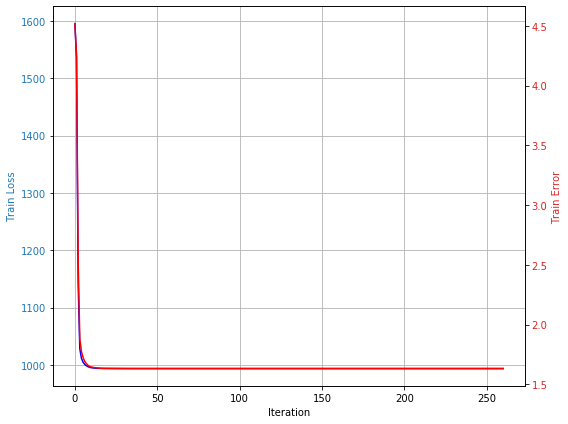

In [33]:
M, G, Mbias, Gbias, train_error, loss, hbar = ALSv2(log_henry_df.values, r, [lambda1, lambda2], 1e-6, 1e-7, 50000, use_global_average=True, verbose=True)
H = M.T.dot(G) + Mbias.T + hbar + Gbias

non_missing_values = ~np.isnan(log_henry_df.values)
H[non_missing_values] = log_henry_df.values[non_missing_values]

In [50]:
log_henry_df.columns

Index(['CURLTUGMZLYLDI-UHFFFAOYSA-N_298K', 'IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K',
       'VNWKTOKETHGBQD-UHFFFAOYSA-N_298K', 'MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K',
       'QQONPFPTGQHPMA-UHFFFAOYSA-N_298K', 'ATUOYWHBWRKTHZ-UHFFFAOYSA-N_298K',
       'HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K', 'UFHFLCQGNIYNRP-UHFFFAOYSA-N_298K',
       'FHNFHKCVQCLJFQ-UHFFFAOYSA-N_298K', 'DNNSSWSSYDEUBZ-UHFFFAOYSA-N_298K',
       'MWUXSHHQAYIFBG-UHFFFAOYSA-N_298K', 'XLYOFNOQVPJJNP-UHFFFAOYSA-N_298K',
       'VLKZOEOYAKHREP-UHFFFAOYSA-N_298K', 'OKKJLVBELUTLKV-UHFFFAOYSA-N_298K',
       'LFQSCWFLJHTTHZ-UHFFFAOYSA-N_298K', 'SFZCNBIFKDRMGX-UHFFFAOYSA-N_298K',
       'UGFAIRIUMAVXCW-UHFFFAOYSA-N_298K', 'UHOVQNZJYSORNB-UHFFFAOYSA-N_298K',
       'XKRFYHLGVUSROY-UHFFFAOYSA-N_298K', 'OTMSDBZUPAUEDD-UHFFFAOYSA-N_298K',
       'VGGSQFUCUMXWEO-UHFFFAOYSA-N_298K', 'QGZKDVFQNNGYKY-UHFFFAOYSA-N_298K',
       'CSCPPACGZOOCGX-UHFFFAOYSA-N_298K', 'IJDNQMDRQITEOD-UHFFFAOYSA-N_298K',
       'KFZMGEQAYNKOFK-UHFFFAOYSA-N_298K', 'BDERNNFJ

[Text(0, 0, 'Carbon Dioxide'),
 Text(0, 0, 'Nitrogen'),
 Text(0, 0, 'Methane'),
 Text(0, 0, 'Oxygen'),
 Text(0, 0, 'Propene'),
 Text(0, 0, 'N-propane'),
 Text(0, 0, 'Acetylene'),
 Text(0, 0, 'Hydrogen'),
 Text(0, 0, 'Xenon'),
 Text(0, 0, 'Krypton'),
 Text(0, 0, 'Nitric oxide'),
 Text(0, 0, 'Water'),
 Text(0, 0, 'N-Hexane'),
 Text(0, 0, 'Methanol'),
 Text(0, 0, 'Ethanol'),
 Text(0, 0, 'Sulfur Hexafluoride'),
 Text(0, 0, 'Carbon monoxide'),
 Text(0, 0, 'Benzene'),
 Text(0, 0, 'Argon'),
 Text(0, 0, 'Ethane'),
 Text(0, 0, 'Ethene'),
 Text(0, 0, 'Ammonia'),
 Text(0, 0, 'Acetone'),
 Text(0, 0, 'N-Butane'),
 Text(0, 0, '2-Propanol'),
 Text(0, 0, '1-Propanol'),
 Text(0, 0, 'Toluene'),
 Text(0, 0, 'N-Pentane'),
 Text(0, 0, 'P-Xylene'),
 Text(0, 0, 'Sulfur dioxide'),
 Text(0, 0, 'Helium'),
 Text(0, 0, '1-butene')]

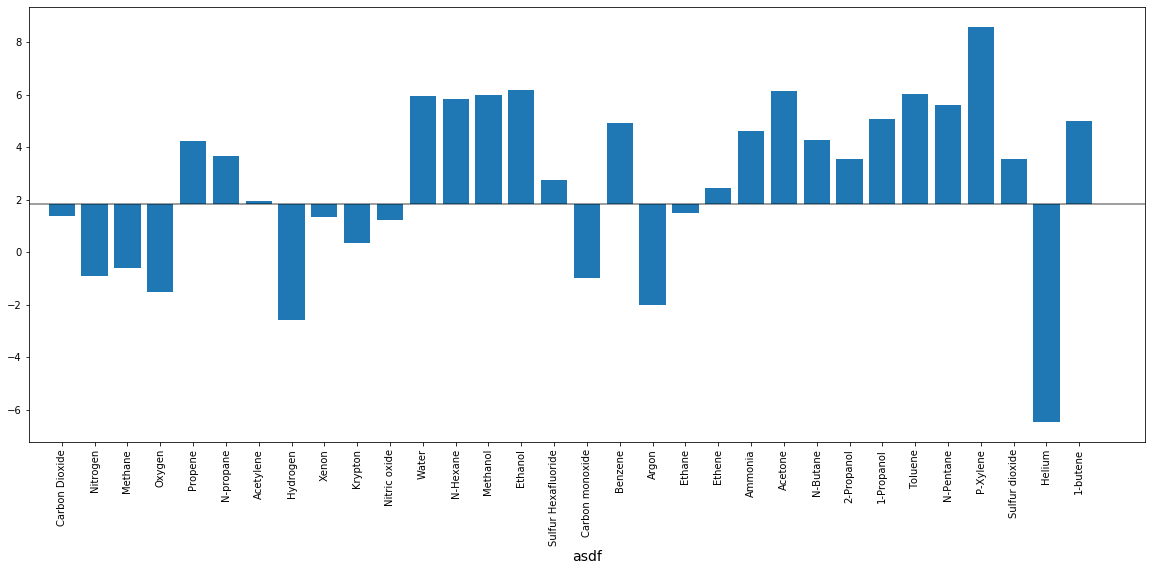

In [56]:
bias = Gbias
mof_or_gas = 'asdf'
fig, ax = plt.subplots(figsize=(20,8))
    
N = len(bias[0,:])
gases = [key_to_gas[gas.split('_')[0]] for gas in log_henry_df.columns]
ax.bar(np.arange(N), bias[0,:], 0.8, hbar, label='Bias')
xlim = ax.get_xlim()
ax.plot(xlim, [hbar,hbar], c='k', lw=1.5, alpha=0.5)
ax.set_xlim(-1, N+1)
ax.set_xlabel(mof_or_gas, fontsize=14)
ax.set_xticks(np.arange(len(gases)))
ax.set_xticklabels(gases, rotation=90)

In [46]:
hbar

1.8504248325422132

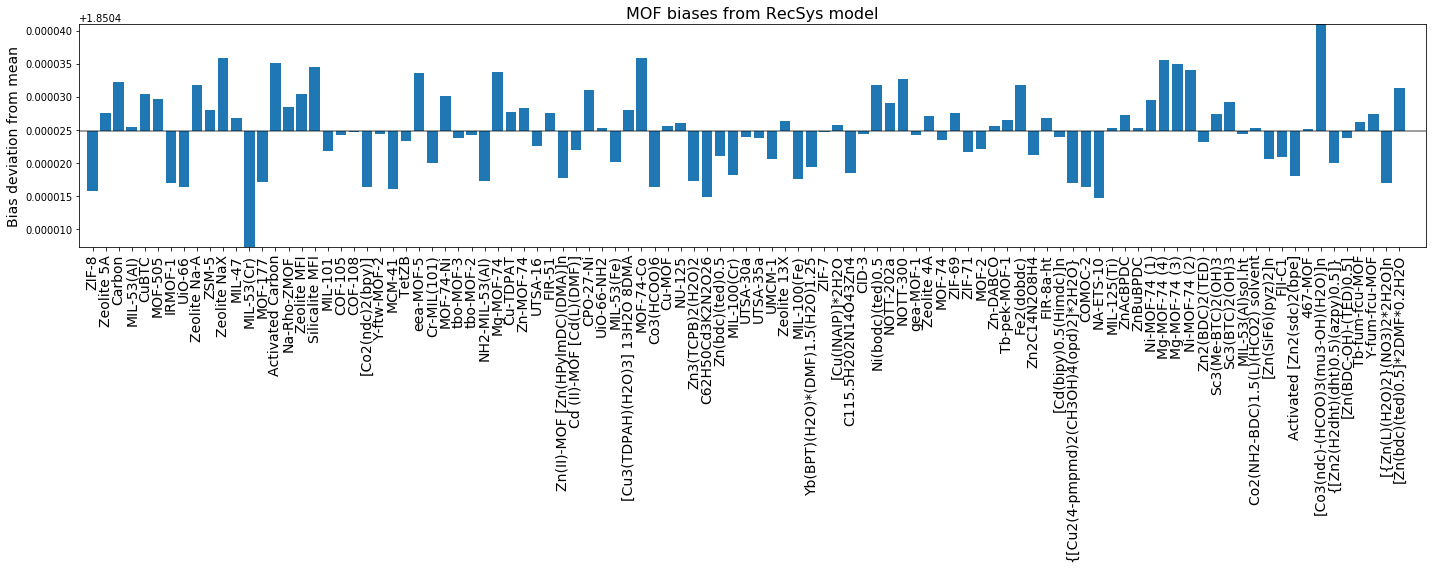

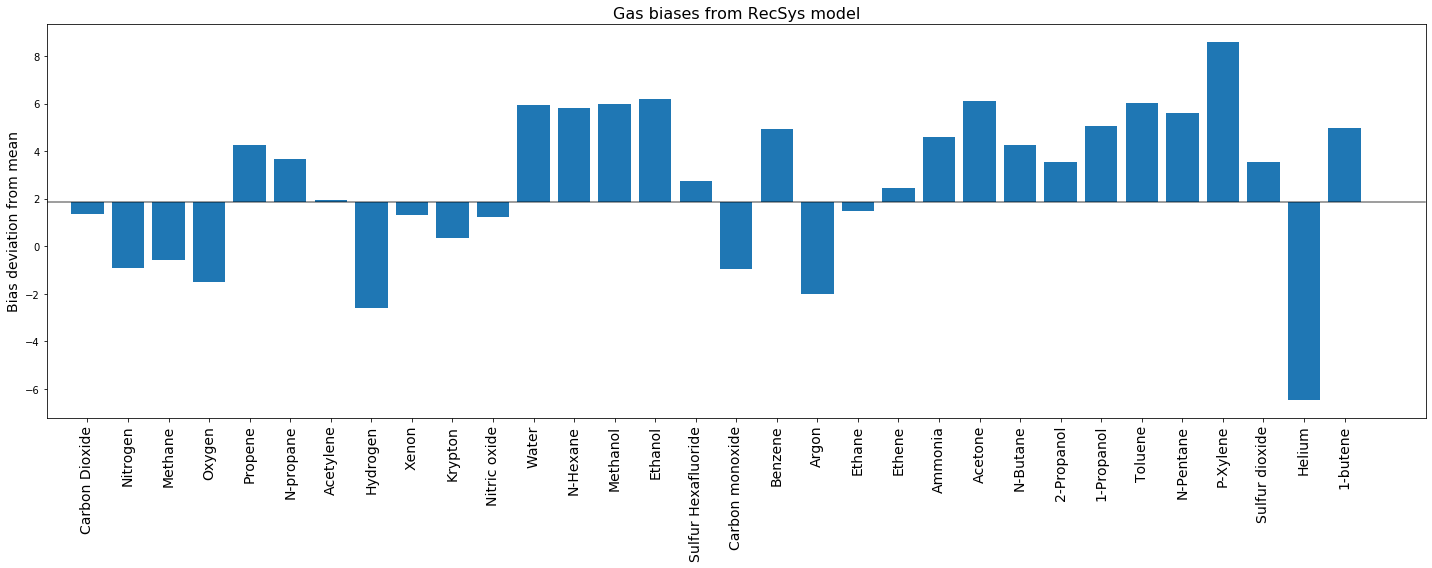

In [60]:
def plot_biases(bias, hbar, mof_or_gas):
    fig, ax = plt.subplots(figsize=(20,8))
    
    N = len(bias[0,:])
    ax.bar(np.arange(N), bias[0,:], 0.8, hbar, label='Bias')
    xlim = ax.get_xlim()
    ax.plot(xlim, [hbar,hbar], c='k', lw=1.5, alpha=0.5)
    ax.set_xlim(-1, N+1)
    ax.set_ylabel('Bias deviation from mean', fontsize=14)
    if mof_or_gas == 'MOF':
        xlabels = [key_to_material[material] for material in log_henry_df.index]
    else:
        xlabels = [key_to_gas[gas.split('_')[0]] for gas in log_henry_df.columns]
    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_xticklabels(xlabels, rotation=90, fontsize=14)
    ax.set_title(mof_or_gas + ' biases from RecSys model', fontsize=16)
    plt.tight_layout()
    plt.savefig('pics/' + mof_or_gas + '_biases_plot.png', format='png', dpi=300)
    plt.show()
plot_biases(Mbias, hbar, 'MOF')
plot_biases(Gbias, hbar, 'Gas')

In [36]:
def find_best_gas_separator(H, is_nan, gas1, gas2, maxnumber=15):
    assert gas1 + '_298K' in log_henry_df.columns and gas2 + '_298K' in log_henry_df.columns
    
    gas_index1 = np.where(log_henry_df.columns == gas1 + '_298K')[0][0]
    gas_index2 = np.where(log_henry_df.columns == gas2 + '_298K')[0][0]
    
    Nm = len(log_henry_df.index)
    selectivities = np.zeros(Nm)
    
    for i in range(Nm):
        selectivities[i] = np.exp(H[i, gas_index1]) / np.exp(H[i, gas_index2])
    sorted_indices = np.argsort(selectivities)
    
    print('Best Materials to separate {:s} and {:s}\n'.format(key_to_gas[gas1], key_to_gas[gas2]))
    for (i, index) in enumerate(sorted_indices[::-1]):
        if i > maxnumber:
            break
        bold_string1 = ''
        bold_string2 = ''
        end_string1 = ''
        end_string2 = ''
        if ~is_nan[index, gas_index1]:
            bold_string1 = '\033[1m'
            end_string1 = '\033[0m'
        if ~is_nan[index, gas_index2]:
            bold_string2 = '\033[1m'
            end_string2 = '\033[0m'
        print('#{:d}: {:40s}\t {:s}{:s}{:s}/{:s}{:s}{:s} = {:.3f}\n'.format(i+1, key_to_material[log_henry_df.index[index]], 
                                                          bold_string1, key_to_gas[gas1], end_string1,
                                                          bold_string2, key_to_gas[gas2], end_string2, selectivities[index]))
    return

find_best_gas_separator(H, np.isnan(log_henry_df.values), gas_to_key['Xenon'], gas_to_key['Krypton'])

Best Materials to separate Xenon and Krypton

#1: Co3(HCOO)6                              	 Xenon/Krypton = 13.955

#2: ZIF-8                                   	 Xenon/Krypton = 5.029

#3: Carbon                                  	 Xenon/Krypton = 4.529

#4: C62H50Cd3K2N2O26                        	 Xenon/Krypton = 4.487

#5: NA-ETS-10                               	 Xenon/Krypton = 4.286

#6: MIL-53(Cr)                              	 Xenon/Krypton = 3.996

#7: NH2-MIL-53(Al)                          	 Xenon/Krypton = 3.837

#8: {[Cu2(4-pmpmd)2(CH3OH)4(opd)2]*2H2O}    	 Xenon/Krypton = 3.778

#9: Yb(BPT)(H2O)*(DMF)1.5(H2O)1.25          	 Xenon/Krypton = 3.685

#10: Zn(II)-MOF [Zn(HPylmDC)(DMA)]n          	 Xenon/Krypton = 3.624

#11: C115.5H202N14O43Zn4                     	 Xenon/Krypton = 3.568

#12: [{Zn(L)(H2O)2}(NO3)2*2H2O]n             	 Xenon/Krypton = 3.534

#13: ZIF-69                                  	 Xenon/Krypton = 3.473

#14: ZIF-71                                  	 Xenon

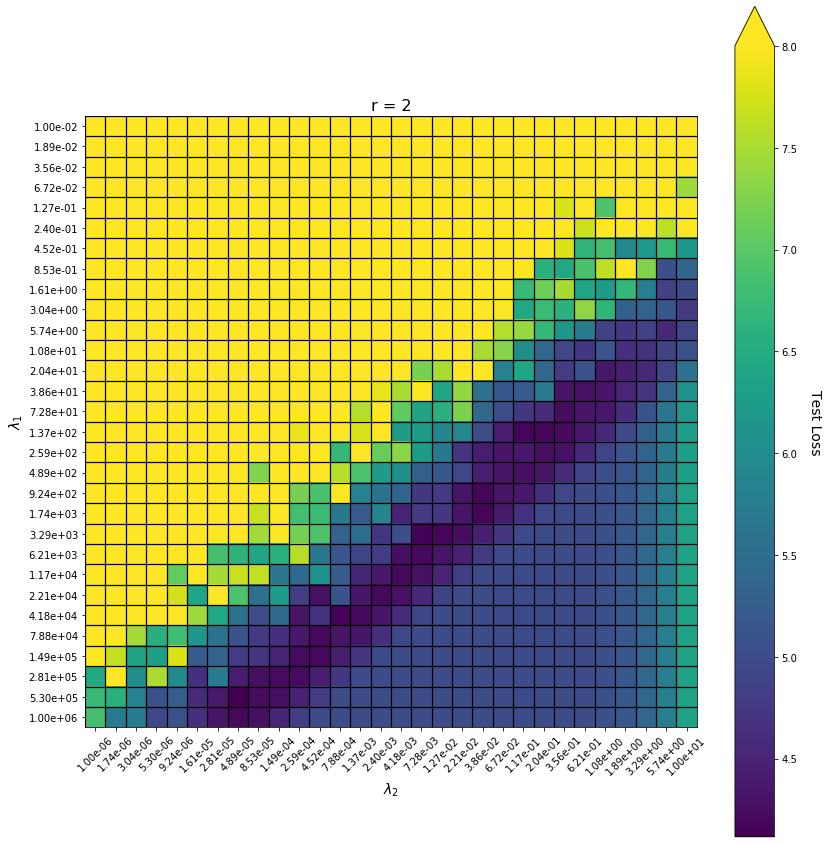

In [21]:
# If there are more than one `r` in CV_dict, specify it. Otherwise, tries to use all data and throws an error with multiple `r`s
def create_loss_heatmap(CV_dict, r_val=None, clip_value=np.inf):
    parity_pred, Mbias, Gbias, r, lambda1, lambda2, err, hbar = extract_data_from_CV_dict(CV_dict)
    if not r_val:
        assert all(r[0] == r)
        correct_r_vals = np.full(r.shape, True)
    else:
        correct_r_vals = (r == r_val)
    
    loss_matrix = np.zeros((len(np.unique(lambda1)), len(np.unique(lambda2))))
    unique_lambda1 = np.unique(lambda1)
    unique_lambda2 = np.unique(lambda2)
    N = len(lambda1)
    for i in range(N):
        if not correct_r_vals[i]:
            continue
        idx1 = np.argwhere(lambda1[i] == unique_lambda1)
        idx2 = np.argwhere(lambda2[i] == unique_lambda2)
        loss_matrix[idx1, idx2] = err[i]
    #return loss_matrix
    
    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(np.clip(loss_matrix, -np.inf, clip_value), interpolation='none', cmap='viridis', norm=matplotlib.colors.Normalize())
    
    for y in range(loss_matrix.shape[0]):
        plt.plot([0-0.5, loss_matrix.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1.25, color='k')
    for x in range(loss_matrix.shape[1]):
        plt.plot([x-0.5, x-0.5], [0-0.5, loss_matrix.shape[0]-0.5], linewidth=1.25, color='k')

    
    extend_string = 'max' if clip_value < np.inf else 'neither'
    cbar = plt.colorbar(im, extend=extend_string)
    cbar.set_label('Test Loss', fontsize=14, rotation=270, labelpad=25)
    
    ax.set_xlabel(r'$\lambda_2$', fontsize=14)
    ax.set_ylabel(r'$\lambda_1$', fontsize=14)
    ax.set_xticks(np.arange(len(unique_lambda1)))
    ax.set_yticks(np.arange(len(unique_lambda2)))
    ax.set_xticklabels(['{0:.2e}'.format(x) for x in unique_lambda2], rotation=45)
    ax.set_yticklabels(['{0:.2e}'.format(x) for x in unique_lambda1])
    ax.set_title('r = {:d}'.format(r[0]), fontsize=16)
    plt.tight_layout()
    plt.savefig('loss_heatmap.png', format='png', dpi=300)
    plt.show()
    return loss_matrix

loss_matrix = create_loss_heatmap(CV_dict, r_val=None, clip_value=8)

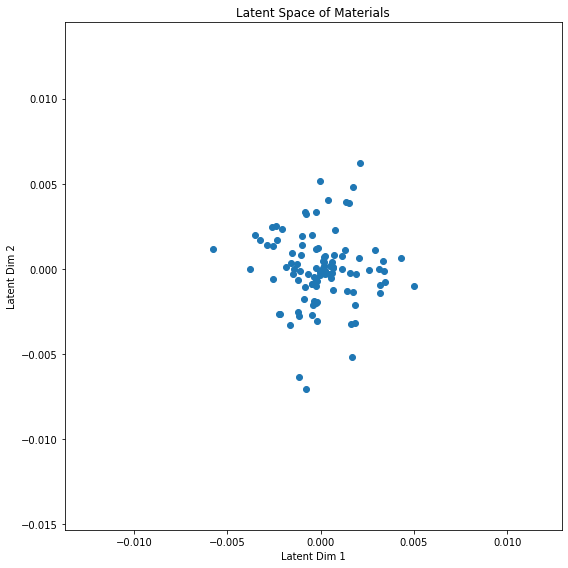

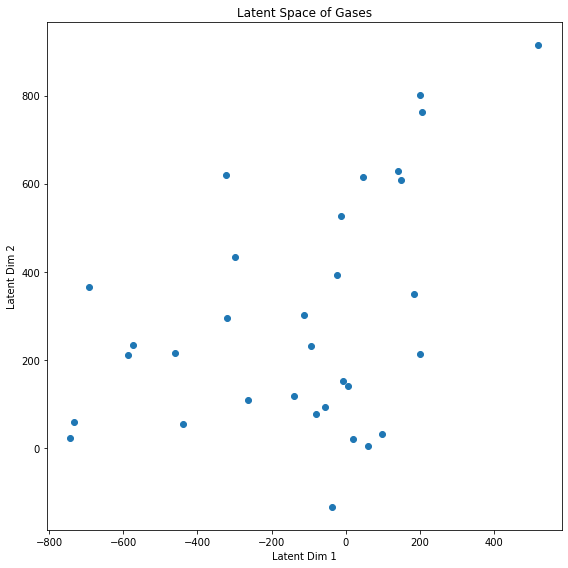

In [22]:
def plot_2d_latent_space(M_or_G, title, filename):
    fig, ax = plt.subplots(figsize=(8,8))
    
    ax.scatter(M_or_G[0,:], M_or_G[1,:])
    ax.set_xlabel('Latent Dim 1')
    ax.set_ylabel('Latent Dim 2')
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig('pics/' + filename, dpi=300, format='png')
    plt.show
    return
plot_2d_latent_space(M, 'Latent Space of Materials', 'mof_latent_space.png')
plot_2d_latent_space(G, 'Latent Space of Gases', 'gas_latent_space.png')

In [23]:
def sort_df_by_freq(df):
    row_sum = np.sum(~np.isnan(df.values), axis=1)
    old_row_order = np.arange(len(row_sum))
    new_row_order = sorted(old_row_order, key=lambda x: row_sum[x], reverse=True)
    col_sum = np.sum(~np.isnan(df.values[new_row_order, :]), axis=0)
    old_col_order = np.arange(len(col_sum))
    new_col_order = sorted(old_col_order, key=lambda x: col_sum[x], reverse=True)
    return new_row_order, new_col_order
new_row_order, new_col_order = sort_df_by_freq(log_henry_df)

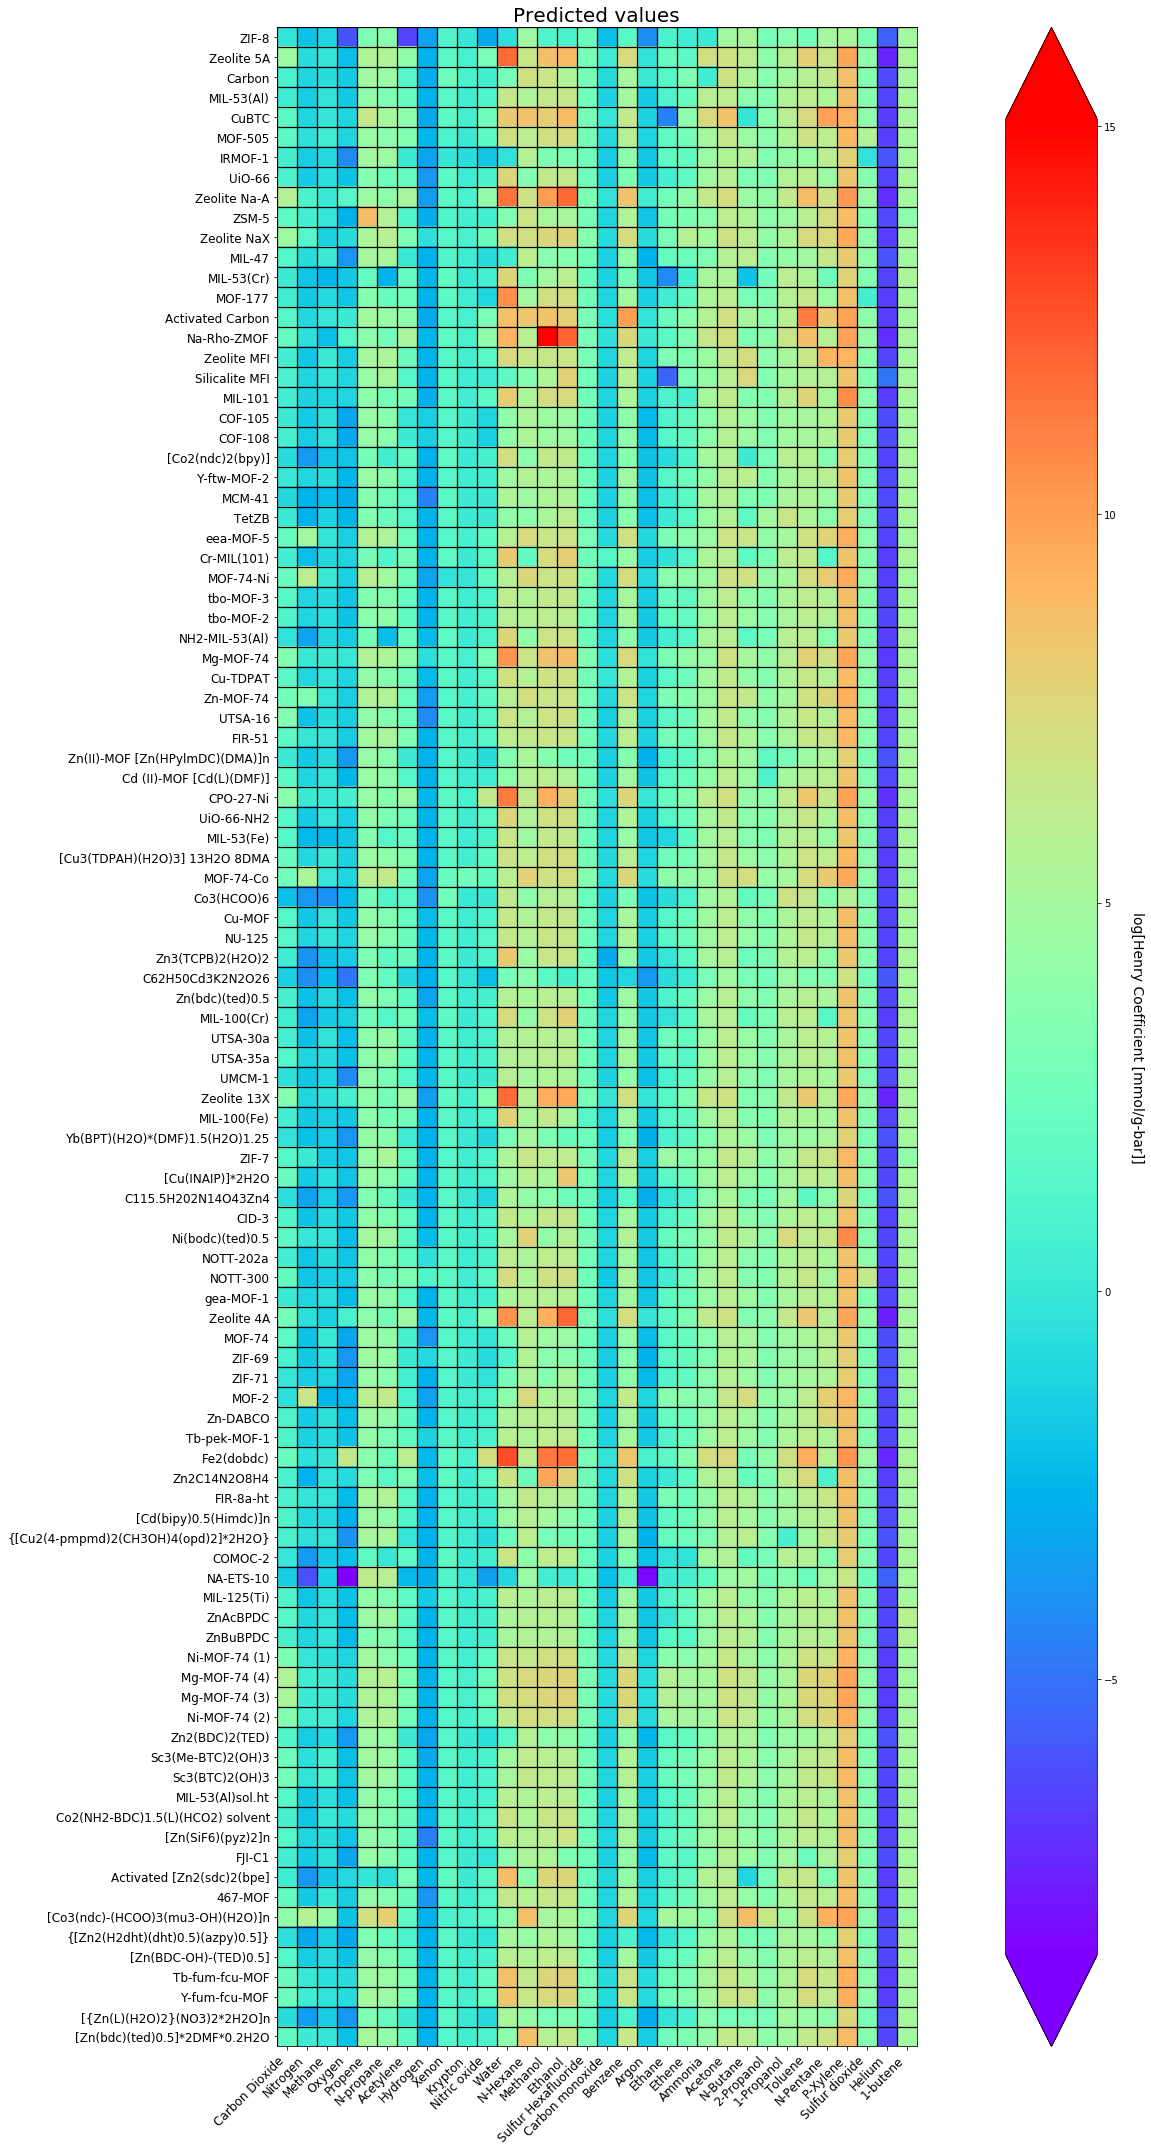

In [24]:
fig = plt.figure(figsize=(25,30))
ax = plt.gca()
temp_h = np.copy(H)

new_row_order, new_col_order = sort_df_by_freq(pd.DataFrame(temp_h))

for y in range(log_henry_df.shape[0]):
    plt.plot([0-0.5, log_henry_df.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1.25, color='k')
for x in range(log_henry_df.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, log_henry_df.shape[0]-0.5], linewidth=1.25, color='k')

plt.imshow(temp_h[new_row_order, :][:, new_col_order], interpolation='none', cmap='rainbow', norm=matplotlib.colors.Normalize())
cbar = plt.colorbar(extend='both')
cbar.set_label('log[Henry Coefficient [mmol/g-bar]]', fontsize=14, rotation=270, labelpad=25)

ax.set_xticks(np.arange(parity_pred.shape[1]))
ax.set_xticklabels([key_to_gas[log_henry_df.columns[i].split('_')[0]] for i in new_col_order], rotation=45, fontsize=12, ha='right')

ax.set_yticks(np.arange(parity_pred.shape[0]))
ax.set_yticklabels([key_to_material[log_henry_df.index[i]] for i in new_row_order], fontsize=12)
plt.title('Predicted values', fontsize=20)
plt.tight_layout()
plt.savefig('pics/CoolPic.png', dpi=300, format='png')

plt.show()

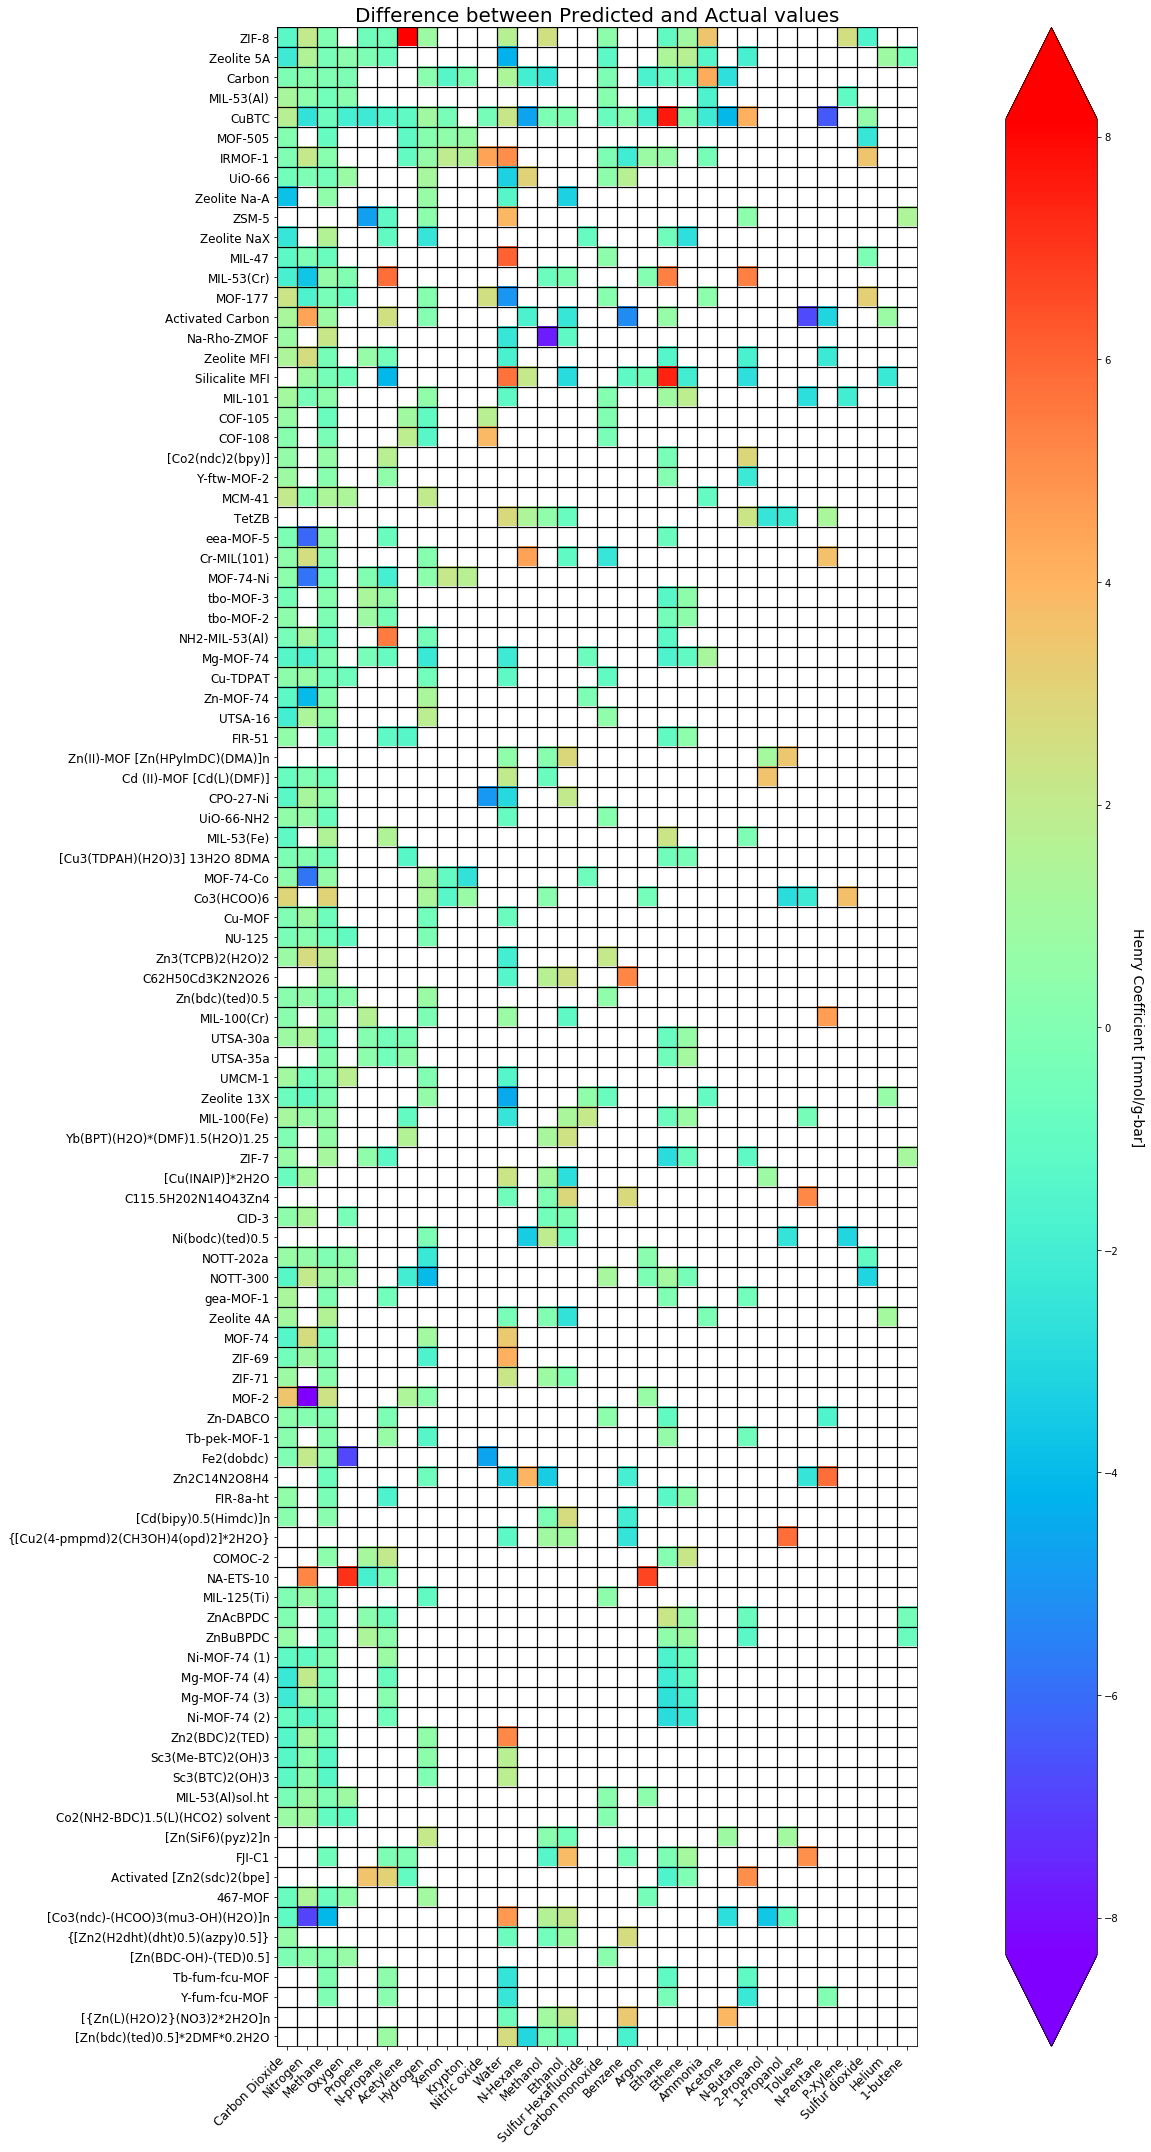

In [25]:
fig = plt.figure(figsize=(25,30))
ax = plt.gca()
h_diff = np.clip(parity_pred - log_henry_df.values, -1e4, 1e6)

for y in range(log_henry_df.shape[0]):
    plt.plot([0-0.5, log_henry_df.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1.25, color='k')
for x in range(log_henry_df.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, log_henry_df.shape[0]-0.5], linewidth=1.25, color='k')

plt.imshow(h_diff[new_row_order, :][:, new_col_order], interpolation='none', cmap='rainbow')
cbar = plt.colorbar(extend='both')
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)

ax.set_xticks(np.arange(parity_pred.shape[1]))
ax.set_xticklabels([key_to_gas[log_henry_df.columns[i].split('_')[0]] for i in new_col_order], rotation=45, fontsize=12, ha='right')

ax.set_yticks(np.arange(parity_pred.shape[0]))
ax.set_yticklabels([key_to_material[log_henry_df.index[i]] for i in new_row_order], fontsize=12)
plt.title('Difference between Predicted and Actual values', fontsize=20)
plt.tight_layout()
plt.savefig('pics/another_coolpic.png', format='png', dpi=300)

plt.show()

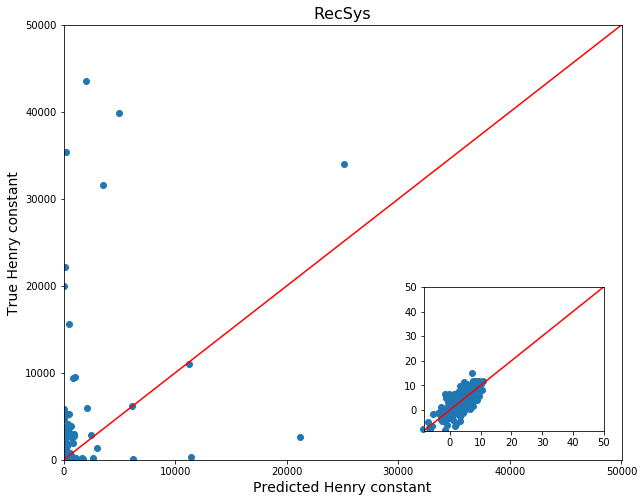

In [26]:
def parity_plot_real(actual, prediction, title):
    fig, ax = plt.subplots(figsize=(10,8))
    
    prediction = prediction.flatten()
    actual = actual.values.flatten()
    mask = ~np.isnan(actual)
    
    ax.scatter(np.exp(prediction[mask]), np.exp(actual[mask]))
    #ax.hexbin(np.exp(prediction[mask]), np.exp(actual[mask]))
    lim = [np.min([np.min(actual[mask]), np.min(np.exp(prediction[mask]))]), np.max([np.max(actual[mask]), np.max(np.exp(prediction[mask]))])]

    ax.plot(lim, lim, c='r')
    ax.set_xlabel('Predicted Henry constant', fontsize=14)
    ax.set_ylabel('True Henry constant', fontsize=14)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    
    ax2 = fig.add_axes([0.625, 0.175, 0.25, 0.25])
    ax2.scatter(prediction[mask], actual[mask])
    ax2.set_xlim([lim[0], lim[1]/1000])
    ax2.set_ylim([lim[0], lim[1]/1000])
    ax2.plot(lim, lim, c='r')
    ax.set_title(title, fontsize=16)
    plt.show()
    
parity_plot_real(log_henry_df, parity_pred, 'RecSys')

In [27]:
def bootstrap_matrix(henry_matrix, rows):
    #assert len(cols) == henry_matrix.shape[1]
    return henry_matrix[rows, :]
cols = np.arange(log_henry_df.values.shape[1])
random_cols = np.sort(np.random.choice(cols, log_henry_df.values.shape[1], replace=True))
bootstrapped_H = bootstrap_matrix(log_henry_df.values, random_cols)
bootstrapped_H

array([[ 4.49610631, -0.61692752, -0.11261008, ...,         nan,
        -7.43121694,  5.17912079],
       [ 0.83608723, -1.11594402, -0.68066782, ...,         nan,
                nan,         nan],
       [ 0.83608723, -1.11594402, -0.68066782, ...,         nan,
                nan,         nan],
       ...,
       [ 1.49350621,         nan, -0.77823385, ...,         nan,
                nan,         nan],
       [-0.29271266, -3.24014075, -0.88660968, ...,         nan,
                nan,         nan],
       [ 3.43541258,  0.09848981,  0.14012874, ...,         nan,
                nan,         nan]])

In [28]:
def bagging_estimation(henry_matrix, r, lambda1, lambda2, q):
    assert q > 0, '`q` is the number of different matrices we will create for the bagging'
    print('Starting Row-Based bagging:')
    #cols = np.arange(henry_matrix.values.shape[1])
    rows = np.arange(henry_matrix.values.shape[0])
    henry_shape = henry_matrix.values.shape
    bagging_henry_coeffs = [[[] for _ in range(henry_shape[1])] for _ in range(henry_shape[0])]
    
    for _ in range(q):
        #random_cols = np.sort(np.random.choice(cols, henry_shape[1], replace=True))
        random_rows = np.sort(np.random.choice(rows, henry_shape[0], replace=True))
        #_, count_idx, count = np.unique(random_cols, return_inverse=True, return_counts=True)
        _, count_idx, count = np.unique(random_rows, return_inverse=True, return_counts=True)
        #bootstrapped_H = bootstrap_matrix(henry_matrix.values, random_cols)
        bootstrapped_H = bootstrap_matrix(henry_matrix.values, random_rows)
        M, G, Mbias, Gbias, train_error, loss, hbar = ALSv2(henry_matrix.values, r, [lambda1, lambda2], 1e-6, 1e-7, 100, use_global_average=True, verbose=False)
        H = M.T.dot(G) + Mbias.T + hbar + Gbias
        temp_H = np.zeros(H.shape)
        for i in range(H.shape[0]):
            for j in range(H.shape[1]):
                #temp_H[i, random_cols[j]] += (H[i, j] / count[count_idx[j]])
                temp_H[random_rows[i], j] += (H[i, j] / count[count_idx[j]])
        temp_idx = np.where(temp_H != 0)
        for i in range(len(temp_idx[0])):
            idx1 = temp_idx[0][i]
            idx2 = temp_idx[1][i]
            bagging_henry_coeffs[idx1][idx2].append(temp_H[idx1, idx2])
        
    return bagging_henry_coeffs, temp_H

bags, asdH = bagging_estimation(log_henry_df, r, lambda1, lambda2, 200)

Starting Row-Based bagging:


[-0.09166677  0.06236556  0.21639789  0.37043022  0.52446255  0.67849489
  0.83252722  0.98655955  1.14059188  1.29462421  1.44865654]


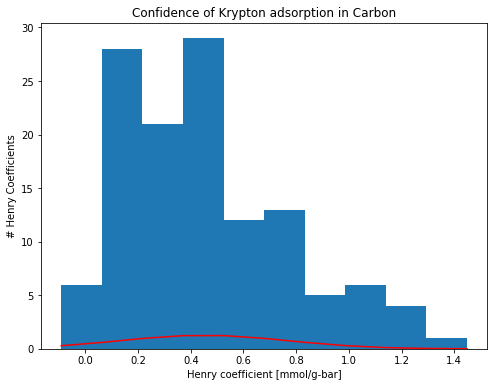

In [29]:
def analyze_bags(bags, gas, mof):
    gas_index = np.where(log_henry_df.columns == gas + '_298K')[0][0]
    mof_index = np.where(log_henry_df.index == mof)[0][0]
    
    bag = bags[mof_index][gas_index]
    avg_henry = np.mean(bag)
    stdev = np.std(bag)
    
    #x = np.linspace(np.min(bag)-5, np.max(bag)+5, num=1000)
    #distribution = (1/(2*np.pi*stdev**2) * np.exp(-(x-avg_henry)**2/(2*stdev**2)))
    
    fig, ax = plt.subplots(figsize=(8,6))
    h = ax.hist(bag)
    xlim = ax.get_xlim()
    distribution = (1/np.sqrt(2*np.pi*stdev**2) * np.exp(-(h[1]-avg_henry)**2/(2*stdev**2)))
    ax.plot(h[1], distribution, color='red')
    ax.set_xlim(xlim)
    ax.set_xlabel('Henry coefficient [mmol/g-bar]')
    ax.set_ylabel('# Henry Coefficients')
    ax.set_title('Confidence of {:s} adsorption in {:s}'.format(key_to_gas[gas], key_to_material[mof]))
    plt.show()
    return avg_henry, stdev

avg_henry, stdev = analyze_bags(bags, gas_to_key['Krypton'], log_henry_df.index[2])

[-1.25238844 -1.00930073 -0.76621301 -0.52312529 -0.28003758 -0.03694986
  0.20613786  0.44922557  0.69231329  0.935401    1.17848872]


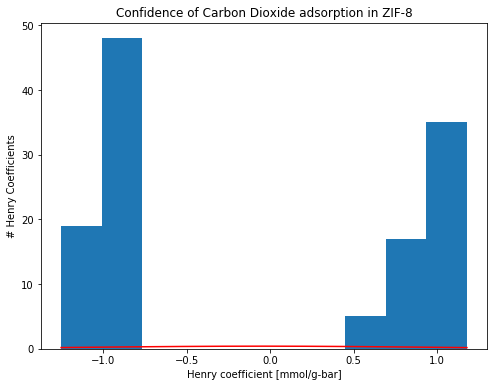

[-1.2525944  -0.36357336  0.52544768  1.41446872  2.30348977  3.19251081
  4.08153185  4.9705529   5.85957394  6.74859498  7.63761602]


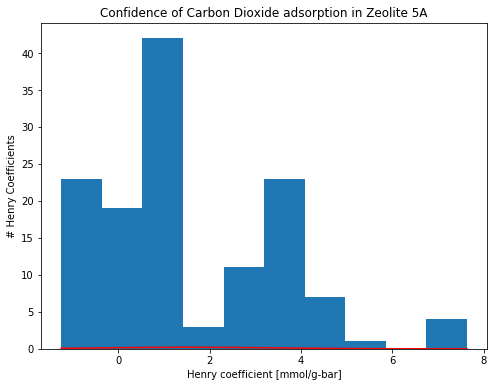

[-1.25246007 -0.18323533  0.88598942  1.95521416  3.0244389   4.09366364
  5.16288838  6.23211312  7.30133786  8.3705626   9.43978734]


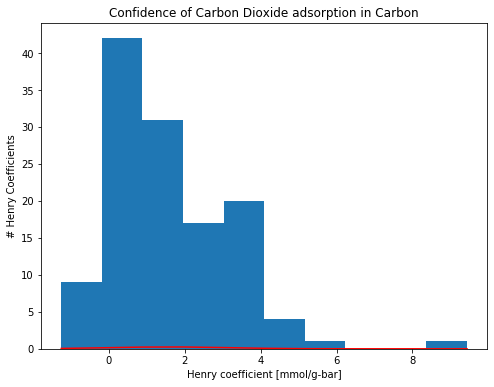

[-0.88869469 -0.15573619  0.57722231  1.31018081  2.04313931  2.77609781
  3.50905631  4.24201481  4.97497331  5.70793181  6.44089031]


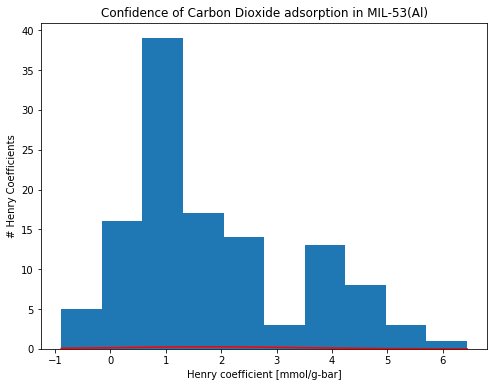

[-0.88869474  0.04317784  0.97505043  1.90692301  2.83879559  3.77066817
  4.70254075  5.63441334  6.56628592  7.4981585   8.43003108]


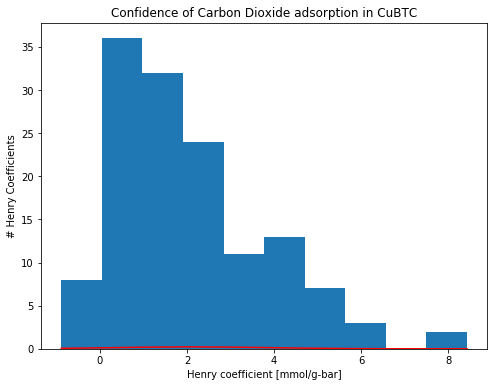

[-1.22098912 -0.27558124  0.66982665  1.61523454  2.56064243  3.50605031
  4.4514582   5.39686609  6.34227398  7.28768186  8.23308975]


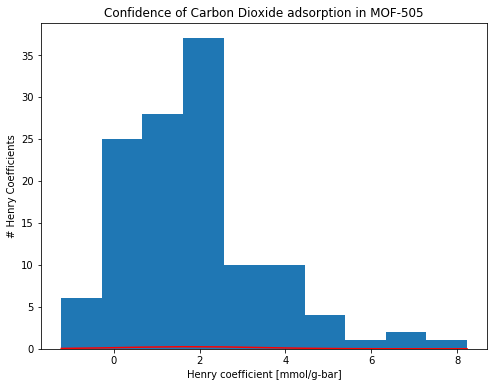

[-0.69561156  0.19725857  1.0901287   1.98299883  2.87586896  3.7687391
  4.66160923  5.55447936  6.44734949  7.34021962  8.23308975]


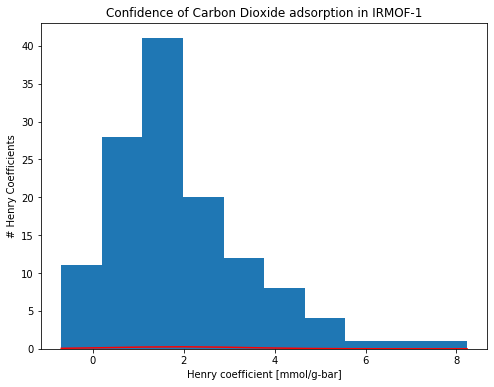

[-1.06653219 -0.00952386  1.04748447  2.1044928   3.16150113  4.21850946
  5.2755178   6.33252613  7.38953446  8.44654279  9.50355112]


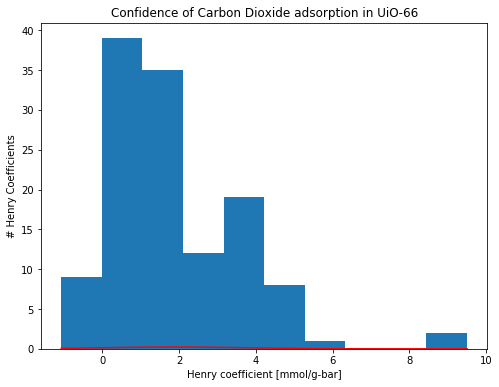

[-1.39122336 -0.42879204  0.53363927  1.49607058  2.45850189  3.4209332
  4.38336451  5.34579582  6.30822713  7.27065844  8.23308975]


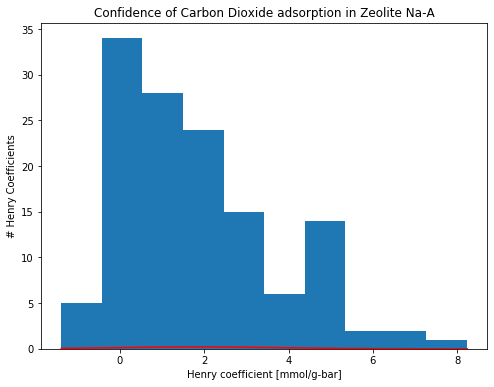

[-1.39122312 -0.4153789   0.56046532  1.53630955  2.51215377  3.487998
  4.46384222  5.43968644  6.41553067  7.39137489  8.36721912]


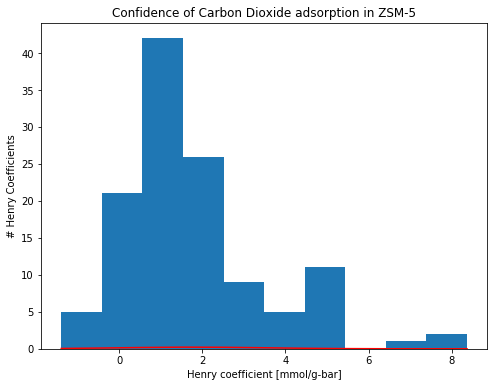

[-1.39122312 -0.41354246  0.5641382   1.54181887  2.51949953  3.49718019
  4.47486085  5.45254152  6.43022218  7.40790284  8.38558351]


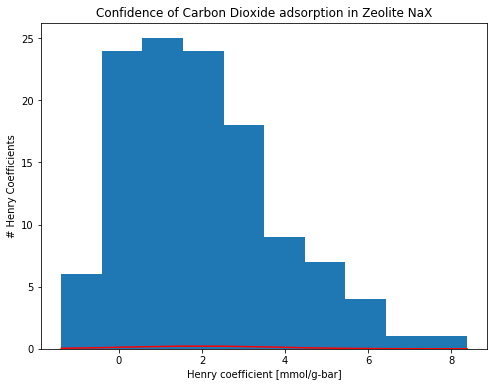

[-1.39122312 -0.33235038  0.72652236  1.7853951   2.84426785  3.90314059
  4.96201333  6.02088607  7.07975881  8.13863156  9.1975043 ]


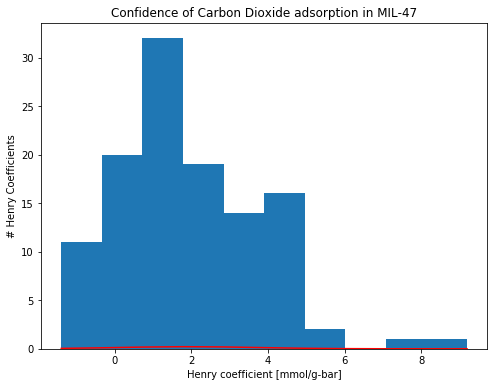

[-1.39122324 -0.40681903  0.57758519  1.5619894   2.54639361  3.53079783
  4.51520204  5.49960625  6.48401047  7.46841468  8.4528189 ]


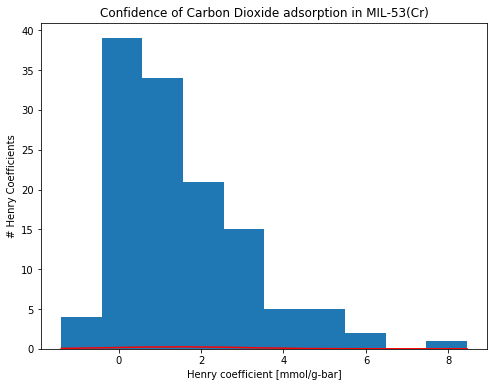

[-1.3912254  -0.55786101  0.27550337  1.10886776  1.94223214  2.77559652
  3.60896091  4.44232529  5.27568968  6.10905406  6.94241845]


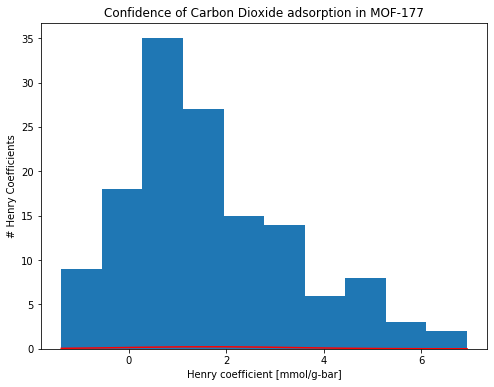

[-1.39122312 -0.42879183  0.53363946  1.49607075  2.45850204  3.42093333
  4.38336462  5.34579591  6.3082272   7.27065849  8.23308978]


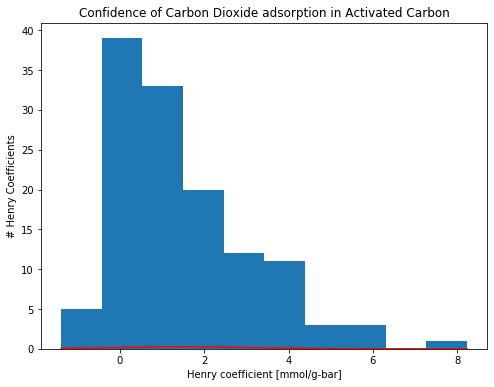

[-1.39122313 -0.54220053  0.30682208  1.15584468  2.00486729  2.85388989
  3.7029125   4.5519351   5.40095771  6.24998031  7.09900292]


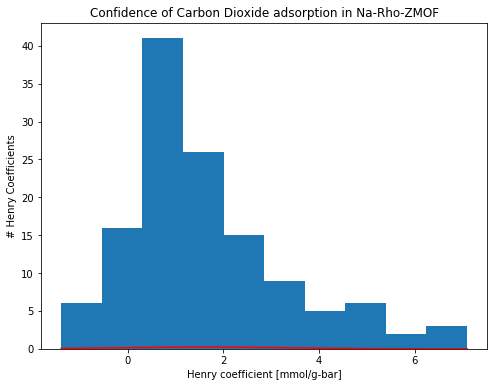

[-0.69081133  0.22355169  1.13791471  2.05227773  2.96664076  3.88100378
  4.7953668   5.70972982  6.62409284  7.53845586  8.45281888]


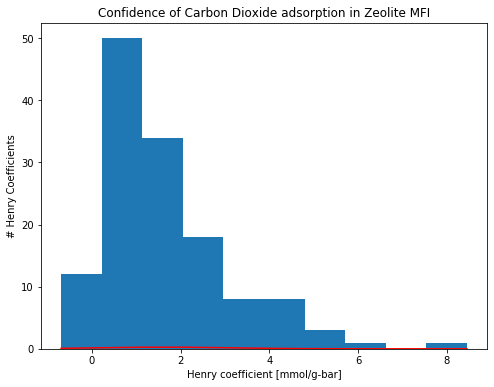

[-0.60740855  0.1632326   0.93387375  1.70451489  2.47515604  3.24579719
  4.01643834  4.78707948  5.55772063  6.32836178  7.09900293]


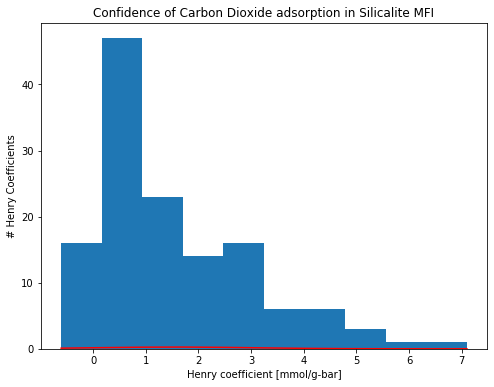

[-0.16711025  0.9354194   2.03794905  3.1404787   4.24300836  5.34553801
  6.44806766  7.55059731  8.65312696  9.75565661 10.85818626]


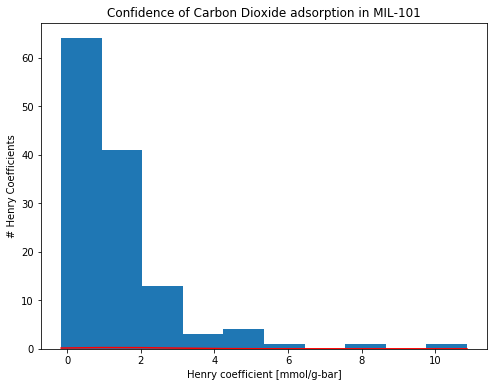

[-1.39122313 -0.79090739 -0.19059164  0.4097241   1.01003984  1.61035558
  2.21067133  2.81098707  3.41130281  4.01161855  4.61193429]


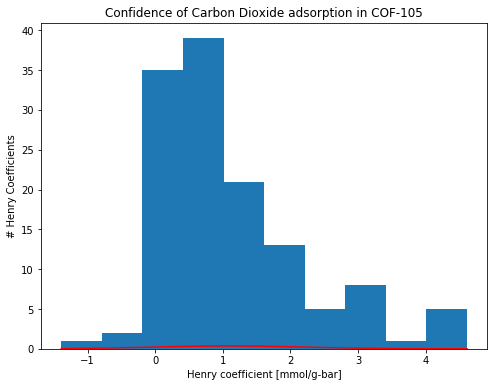

In [30]:
gas_key = gas_to_key['Carbon Dioxide']
for mof_key in log_henry_df.index[:20]:
    avg_henry, stdev = analyze_bags(bags, gas_key, mof_key)